This is a piece of code based on TeNPy following the idea in Frank Pollmann's paper about the detection of 1d SPT.

The basic idea is as follows:
 - With a given ground state (GS) $|\psi\rangle$ in `iMPS` format, and its corresponding symmetry $S$ of interest, one calculates the `sandwich` $\langle \psi | S | \psi \rangle$ as the transfer matrix $T$.
 - With the transfer matrix $T$, one calculates its primary eigenvector, which corresponds to the largest eigenvalue `1.0`, and denotes it as $U^S$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tenpy.networks.site import SpinHalfSite
from tenpy.networks.mps import TransferMatrix
import tenpy.linalg.np_conserved as npc

from utility import linspace

# Functions for calculating the SPT signatures

In [15]:
def detect_SPT_onsite(psi, symmetry):
    assert symmetry in ['Sigmax', 'Sigmay', 'Sigmaz', 'upperSigmaz', 'lowerSigmaz']
    if symmetry=='Sigmax' or symmetry=='Sigmay' or symmetry=='Sigmaz':
        op = symmetry
        
        s = SpinHalfSite(conserve=None)
        op = npc.expm(1.j * (np.pi / 2) * s.get_op(op))
        
        # First of all, save a copy of the input wavefunction psi
        psi_copy = psi.copy()
        for i in range(psi_copy.L): # apply the op to all sites
            psi_copy.apply_local_op(i, op)
        
        TM = TransferMatrix(psi, psi_copy)
        eta, G = TM.eigenvectors(num_ev=1)
#         if not np.allclose(eta, 1):
#             print(f'eta={eta}')
#             raise ValueError('The largest eigenvalue of the transfer matrix is not 1!')
        if not np.allclose(np.abs(eta), 1, atol=0.01):
            return 0
        
        U = G[0]
        Uop = U.split_legs()
        chi=(Uop.shape[0])
        Uop *= np.sqrt(chi) # rescale it
        
    else: # if the symmetry is the upper or the lower Sigmaz
        op = 'Sigmaz'
        
        
        s = SpinHalfSite(conserve=None)
        op = npc.expm(1.j * (np.pi / 2) * s.get_op(op))
        
        # First of all, save a copy of the input wavefunction psi
        psi_copy = psi.copy()
        # Then calculate the specific properties of the wavefunction
        N = psi_copy.L // 4 # The number of unicells
        
        if symmetry == 'upperSigmaz':
            for i in range(N):
                psi_copy.apply_local_op(2*i, op)
                psi_copy.apply_local_op(2*i+3, op)
        else:
            for i in range(N):
                psi_copy.apply_local_op(2*i+1, op)
                psi_copy.apply_local_op(2*i+2, op)
            
        
        TM = TransferMatrix(psi, psi_copy)
        eta, G = TM.eigenvectors(num_ev=1)
#         if not np.allclose(eta, 1):
#             print(f'eta={eta}')
#             raise ValueError('The largest eigenvalue of the transfer matrix is not 1!')
        if not np.allclose(np.abs(eta), 1, atol=0.01):
            return 0
        
        U = G[0]
        Uop = U.split_legs()
        chi=(Uop.shape[0])
        Uop *= np.sqrt(chi) # rescale it
        
    return Uop, chi
        

In [12]:
def detect_SPT_D2(psi):
    
    op_list = ['Sigmax', 'Sigmay']
    U_list = []
    
    for op in op_list:
        
        
        s = SpinHalfSite(conserve=None)
        op = npc.expm(1.j * (np.pi/2) * s.get_op(op))
        
        # First of all, save a copy of the input wavefunction psi
        psi_copy = psi.copy()
        for i in range(psi_copy.L):
            psi_copy.apply_local_op(i, op)
        
        TM = TransferMatrix(psi, psi_copy)
        eta, G = TM.eigenvectors(num_ev=1)
#         if not np.allclose(eta, 1):
#             print(f'eta={eta}')
#             raise ValueError('The largest eigenvalue of the transfer matrix is not 1!')
        if not np.allclose(np.abs(eta), 1, atol=0.01):
            return 0
        
        U = G[0]
        Uop = U.split_legs()
        chi=(Uop.shape[0])
        Uop *= np.sqrt(chi) # rescale it
        U_list.append(Uop)

    U1 = U_list[0]
    U2 = U_list[1]
    U12 = npc.tensordot(U1, U2, axes=([1], [0]))
    U21 = npc.tensordot(U2, U1, axes=([1], [0]))
    return npc.inner(U12, U21.conj()) / chi
#     print(npc.inner(U12, U21.conj()) / chi)

In [4]:
def detect_SPT_D2_upper_Z(psi):
    
#     op_list = ['Sigmax', 'Sigmay']
    U_list = []
    
    op = 'Sigmaz'
    
    
    ###### The upper ######
    # First of all, save a copy of the input wavefunction psi
    psi_copy = psi.copy()
    
    # Then calculate the specific properties of the wavefunction
    N = psi_copy.L // 4 # The number of unicells
    for i in range(N):
        psi_copy.apply_local_op(2*i, op)
        psi_copy.apply_local_op(2*i+3, op)

    TM = TransferMatrix(psi, psi_copy)
    eta, G = TM.eigenvectors(num_ev=1)
#         if not np.allclose(eta, 1):
#             print(f'eta={eta}')
#             raise ValueError('The largest eigenvalue of the transfer matrix is not 1!')
    if not np.allclose(np.abs(eta), 1, atol=0.01):
        return 0
    
    
    U = G[0]
    Uop = U.split_legs()
    chi=(Uop.shape[0])
    Uop *= np.sqrt(chi) # rescale it
    U_list.append(Uop)

    ###### The lower ######
    # First of all, save a copy of the input wavefunction psi
    psi_copy = psi.copy()
    
    # Then calculate the specific properties of the wavefunction
    N = psi_copy.L // 4 # The number of unicells
    for i in range(N): # apply the operators
        psi_copy.apply_local_op(2*i+1, op)
        psi_copy.apply_local_op(2*i+2, op)

    TM = TransferMatrix(psi, psi_copy)
    eta, G = TM.eigenvectors(num_ev=1)
#         if not np.allclose(eta, 1):
#             print(f'eta={eta}')
#             raise ValueError('The largest eigenvalue of the transfer matrix is not 1!')
    if not np.allclose(np.abs(eta), 1, atol=0.01):
        return 0
    
    
    U = G[0]
    Uop = U.split_legs()
    chi=(Uop.shape[0])
    Uop *= np.sqrt(chi) # rescale it
    U_list.append(Uop)
        
    
    U1 = U_list[0]
    U2 = U_list[1]
    U12 = npc.tensordot(U1, U2, axes=([1], [0]))
    U21 = npc.tensordot(U2, U1, axes=([1], [0]))
    return npc.inner(U12, U21.conj()) / chi

In [5]:
def detect_SPT_spatial_inv(psi, Op='inversion'):
    
    # create a copy of the wavefunction in form B. Only for a gaurantee. It should be of form B by defaultcalcu
    psi_copy = psi.copy()
    psi_copy.convert_form('B')
    
    if Op=='inversion': # apply the spatial inversion op to the wavefunction
        psi_inv = psi_copy.spatial_inversion() #Form spatial reflection of the WF
    elif Op=='time_reversal': # apply the time reversal op to the wavefunction
        psi_inv = psi_copy.copy()
        for i in range(psi_inv.L):
            t=psi_inv.get_B(i).copy()
            
            for array in t:
                array_list = list(array)
                array_list[0] = np.conj(array_list[0])
                array = tuple(array_list)
            psi_inv.set_B(i, t)
    
    # create the transfer matrix corresponding to the original wavefunction and the tranformed wavefunction
    TM = TransferMatrix(psi_inv, psi_copy)
    
    # calculate the largest eigenvalue and the corresponding eigenvector
    eta, G = TM.eigenvectors(num_ev=1)

    # if eta, i.e. the largest eigenvalue is not 1 (not close enough to 1)
    if not np.allclose(np.abs(eta), 1, atol=0.01):
        print("Not Symmetric under the Spatial Inversion. Eta = ", eta)
        return 0
    
    U = G[0]
    Uop = U.split_legs() # this is necessary for TeNPy, or we cannot get the matrix but a vector
    chi=(Uop.shape[0])
    Uop *= np.sqrt(chi) # rescale it
    return npc.inner(U, U.conj())

In [6]:
from kitaev_ladder_snake1 import load_data, run_atomic

In [7]:
import re
import os
import h5py
from tenpy.tools import hdf5_io

In [8]:
string = 'KitaevLadder_chi_256_Jx_0.07_Jy_0.07_Jz_1.0_L_4.h5'
pattern = r"[-+]?\d*\.\d+|\d+"
re.findall(pattern, string)

['256', '0.07', '0.07', '1.0', '4', '5']

# Get the iMPS' for the diagram line of our interest

In [10]:
# This is the dictionary for storing the wave functions (iMPS)
psi_dict = {}

In [ ]:
# Define the parameters
num = 101
Jx_list = linspace(1.0, 2.0, num)
# The initial parameters
Jx = 1.0
Jy = 1.0
Jz = 1.0
L = 2
chi = 128

In [ ]:


# psi_list = []
# result_list = []

### First of all, create the stable initial point, from smaller chi to larger chi
chi_list = [4, 8, 16, 32, 64, 128]

initial_psi = None
for chi in chi_list:
    result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi, initial_psi=initial_psi, bc='periodic', bc_MPS='infinite')
    psi = result['psi']
    initial_psi = psi.copy()
    

In [11]:
psi_dict[(Jx, Jy, Jz)] = psi.copy()
psi_111 = psi.copy()


initial_psi = psi_111.copy()
for Jx in Jx_list[1:]:
    Jy = np.round(2 - Jx, decimals=2)
    result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi, initial_psi=initial_psi, bc='periodic', bc_MPS='infinite')
    psi = result['psi'].copy()
    psi_dict[(Jx, Jy, Jz)] = psi.copy()
    initial_psi = psi.copy()
    
initial_psi = psi_111.copy()
for Jx in Jx_list[1:]:
    Jx = np.round(2 - Jx, decimals=2)
    Jy = np.round(2 - Jx, decimals=2)
    result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi, initial_psi=initial_psi, bc='periodic', bc_MPS='infinite')
    psi = result['psi'].copy()
    psi_dict[(Jx, Jy, Jz)] = psi.copy()
    initial_psi = psi.copy()

Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.01 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.99 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=Tr

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8388550614166306, S = nan, norm_err = 1.7e-12
Current memory usage 163.1 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0359e-19, max_E_trunc = 1.4211e-13
MPS bond dimensions: [53, 57, 35, 58]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8388550614166093, S = nan, norm_err = 1.1e-12
Current memory usage 163.1 MB, time elapsed: 7.6 s
Delta E = 2.1316e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3086e-19, max_E_trunc = 3.9790e-13
MPS bond dimensions: [46, 58, 35, 58]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8389176976376760, S = nan, norm_err = 2.5e-13
Current memory usage 164.1 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0391e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [51, 58, 33, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8389176976375552, S = nan, norm_err = 5.8e-13
Current memory usage 164.1 MB, time elapsed: 8.0 s
Delta E = 1.2079e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1001e-19, max_E_trunc = 3.1264e-13
MPS bond dimensions: [48, 54, 34, 57]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8390054666264817, S = nan, norm_err = 8.9e-13
Current memory usage 164.9 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.2961e-20, max_E_trunc = 3.6948e-13
MPS bond dimensions: [51, 60, 33, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8390054666265030, S = nan, norm_err = 6.4e-13
Current memory usage 165.2 MB, time elapsed: 8.0 s
Delta E = -2.1316e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0236e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [46, 55, 35, 56]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8391184469633366, S = nan, norm_err = 1.9e-13
Current memory usage 165.2 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.4174e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [52, 58, 35, 55]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8391184469631909, S = nan, norm_err = 7.5e-13
Current memory usage 165.2 MB, time elapsed: 8.0 s
Delta E = 1.4566e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0864e-19, max_E_trunc = -5.6843e-14
MPS bond dimensions: [47, 57, 32, 58]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8392567401110185, S = nan, norm_err = 9.8e-14
Current memory usage 165.4 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.9459e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [52, 58, 35, 56]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8392567401111108, S = nan, norm_err = 6.4e-13
Current memory usage 165.4 MB, time elapsed: 8.0 s
Delta E = -9.2371e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2080e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [43, 54, 33, 58]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8394204707450292, S = nan, norm_err = 2.1e-13
Current memory usage 165.4 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0218e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [52, 58, 34, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8394204707449191, S = nan, norm_err = 2.4e-13
Current memory usage 165.4 MB, time elapsed: 8.1 s
Delta E = 1.1013e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1728e-19, max_E_trunc = 3.4106e-13
MPS bond dimensions: [47, 56, 34, 59]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8396097871592403, S = nan, norm_err = 4.7e-13
Current memory usage 165.4 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1847e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [49, 58, 36, 56]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8396097871592048, S = nan, norm_err = 3.3e-13
Current memory usage 165.4 MB, time elapsed: 8.1 s
Delta E = 3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1713e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [45, 56, 36, 58]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8398248617561883, S = nan, norm_err = 1.3e-13
Current memory usage 165.4 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3963e-19, max_E_trunc = 1.4211e-13
MPS bond dimensions: [52, 58, 34, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8398248617561563, S = nan, norm_err = 3.6e-13
Current memory usage 165.4 MB, time elapsed: 7.9 s
Delta E = 3.1974e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3728e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [47, 56, 34, 58]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8400658916212400, S = nan, norm_err = 3.9e-13
Current memory usage 165.7 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2670e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [52, 58, 34, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8400658916211938, S = nan, norm_err = 2.2e-13
Current memory usage 165.7 MB, time elapsed: 8.0 s
Delta E = 4.6185e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3160e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [48, 59, 35, 58]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8403330991885980, S = nan, norm_err = 3.7e-13
Current memory usage 166.4 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2429e-19, max_E_trunc = 2.5580e-13
MPS bond dimensions: [49, 61, 37, 60]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8403330991887898, S = nan, norm_err = 5.1e-13
Current memory usage 166.4 MB, time elapsed: 8.0 s
Delta E = -1.9185e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1810e-19, max_E_trunc = 2.8422e-13
MPS bond dimensions: [48, 58, 35, 61]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8406267330042212, S = nan, norm_err = 5.7e-13
Current memory usage 166.4 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3573e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [51, 59, 36, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8406267330043136, S = nan, norm_err = 5.4e-13
Current memory usage 166.4 MB, time elapsed: 8.2 s
Delta E = -9.2371e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2605e-19, max_E_trunc = 3.9790e-13
MPS bond dimensions: [48, 60, 36, 62]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8409470685916887, S = nan, norm_err = 1.3e-12
Current memory usage 167.0 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3246e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [51, 60, 35, 60]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8409470685917171, S = nan, norm_err = 6.0e-13
Current memory usage 167.0 MB, time elapsed: 8.2 s
Delta E = -2.8422e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2058e-19, max_E_trunc = 3.6948e-13
MPS bond dimensions: [48, 59, 36, 60]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8412944094305495, S = nan, norm_err = 1.0e-12
Current memory usage 167.0 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2527e-19, max_E_trunc = -8.5265e-14
MPS bond dimensions: [51, 61, 35, 60]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8412944094305033, S = nan, norm_err = 6.5e-13
Current memory usage 167.0 MB, time elapsed: 8.4 s
Delta E = 4.6185e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.6936e-20, max_E_trunc = 1.7053e-13
MPS bond dimensions: [48, 58, 34, 58]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8416690880553723, S = nan, norm_err = 8.1e-13
Current memory usage 167.5 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3104e-19, max_E_trunc = 1.4211e-13
MPS bond dimensions: [55, 62, 35, 62]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8416690880554114, S = nan, norm_err = 8.4e-13
Current memory usage 167.5 MB, time elapsed: 8.3 s
Delta E = -3.9080e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.7194e-20, max_E_trunc = 1.9895e-13
MPS bond dimensions: [47, 60, 36, 60]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8420714672866332, S = nan, norm_err = 1.2e-12
Current memory usage 167.5 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2130e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [54, 62, 39, 63]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8420714672867149, S = nan, norm_err = 8.0e-13
Current memory usage 167.5 MB, time elapsed: 8.4 s
Delta E = -8.1712e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0030e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [49, 61, 36, 64]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8425019416059030, S = nan, norm_err = 1.5e-12
Current memory usage 167.5 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0814e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [55, 64, 37, 65]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8425019416060664, S = nan, norm_err = 1.5e-12
Current memory usage 167.7 MB, time elapsed: 8.7 s
Delta E = -1.6342e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1911e-19, max_E_trunc = 2.8422e-13
MPS bond dimensions: [49, 61, 38, 64]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8429609386909824, S = nan, norm_err = 2.7e-12
Current memory usage 168.4 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1167e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [57, 63, 36, 63]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8429609386910997, S = nan, norm_err = 1.5e-12
Current memory usage 168.4 MB, time elapsed: 8.7 s
Delta E = -1.1724e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0750e-19, max_E_trunc = 0.0000e+00
MPS bond dimensions: [50, 62, 37, 62]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8434489211262530, S = nan, norm_err = 5.2e-12
Current memory usage 175.1 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1944e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [58, 66, 40, 66]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8434489211263028, S = nan, norm_err = 5.7e-13
Current memory usage 175.1 MB, time elapsed: 9.0 s
Delta E = -4.9738e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.7511e-20, max_E_trunc = 5.6843e-13
MPS bond dimensions: [51, 63, 39, 64]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8439663883084663, S = nan, norm_err = 8.1e-12
Current memory usage 175.1 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0317e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [55, 66, 38, 65]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8439663883086510, S = nan, norm_err = 1.2e-12
Current memory usage 175.1 MB, time elapsed: 9.0 s
Delta E = -1.8474e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1016e-19, max_E_trunc = 2.8422e-13
MPS bond dimensions: [54, 63, 37, 65]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8445138785740411, S = nan, norm_err = 1.6e-11
Current memory usage 175.1 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0447e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [56, 66, 38, 66]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8445138785740767, S = nan, norm_err = 7.6e-13
Current memory usage 175.1 MB, time elapsed: 9.1 s
Delta E = -3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1990e-19, max_E_trunc = 3.9790e-13
MPS bond dimensions: [52, 64, 42, 65]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8450919715695804, S = nan, norm_err = 2.9e-11
Current memory usage 175.8 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2804e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [54, 66, 40, 67]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8450919715695804, S = nan, norm_err = 9.5e-13
Current memory usage 175.8 MB, time elapsed: 9.1 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3197e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [53, 67, 38, 65]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8457012909011929, S = nan, norm_err = 5.6e-11
Current memory usage 176.6 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7022e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [57, 68, 42, 66]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8457012909012320, S = nan, norm_err = 7.8e-13
Current memory usage 176.6 MB, time elapsed: 9.1 s
Delta E = -3.9080e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1974e-19, max_E_trunc = 3.9790e-13
MPS bond dimensions: [54, 66, 39, 68]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8463425071015394, S = nan, norm_err = 1.0e-10
Current memory usage 178.3 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2274e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [56, 69, 40, 69]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8463425071013972, S = nan, norm_err = 9.8e-13
Current memory usage 178.3 MB, time elapsed: 9.3 s
Delta E = 1.4211e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3468e-19, max_E_trunc = 0.0000e+00
MPS bond dimensions: [53, 65, 40, 66]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8470163409545819, S = nan, norm_err = 1.9e-10
Current memory usage 178.8 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1693e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [54, 69, 42, 68]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8470163409544611, S = nan, norm_err = 6.9e-13
Current memory usage 178.8 MB, time elapsed: 9.5 s
Delta E = 1.2079e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1885e-19, max_E_trunc = 3.9790e-13
MPS bond dimensions: [54, 67, 40, 65]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8477235672361978, S = nan, norm_err = 3.6e-10
Current memory usage 179.2 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2291e-19, max_E_trunc = 3.4106e-13
MPS bond dimensions: [55, 68, 41, 70]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8477235672363435, S = nan, norm_err = 7.3e-13
Current memory usage 179.2 MB, time elapsed: 9.8 s
Delta E = -1.4566e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2627e-19, max_E_trunc = 3.4106e-13
MPS bond dimensions: [55, 68, 40, 66]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8484650189320924, S = nan, norm_err = 6.8e-10
Current memory usage 180.2 MB, time elapsed: 3.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3258e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [57, 69, 44, 70]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8484650189321457, S = nan, norm_err = 4.2e-13
Current memory usage 180.3 MB, time elapsed: 10.0 s
Delta E = -5.3291e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2252e-19, max_E_trunc = 7.1054e-13
MPS bond dimensions: [59, 69, 39, 68]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8492415920124508, S = nan, norm_err = 1.3e-09
Current memory usage 182.6 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0471e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [60, 71, 40, 72]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8492415920124898, S = nan, norm_err = 3.9e-13
Current memory usage 182.6 MB, time elapsed: 10.2 s
Delta E = -3.9080e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1218e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [54, 64, 41, 71]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8500542508568074, S = nan, norm_err = 2.4e-09
Current memory usage 182.6 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.1033e-20, max_E_trunc = 8.5265e-14
MPS bond dimensions: [61, 68, 41, 73]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8500542508570135, S = nan, norm_err = 3.2e-13
Current memory usage 184.5 MB, time elapsed: 10.8 s
Delta E = -2.0606e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2700e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [57, 66, 44, 71]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8509040344471011, S = nan, norm_err = 4.5e-09
Current memory usage 184.5 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1366e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [62, 74, 41, 74]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8509040344471117, S = nan, norm_err = 3.6e-13
Current memory usage 184.5 MB, time elapsed: 11.0 s
Delta E = -1.0658e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2042e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [56, 68, 41, 72]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8517920634718976, S = nan, norm_err = 8.5e-09
Current memory usage 184.8 MB, time elapsed: 3.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.9790e-20, max_E_trunc = 1.4211e-13
MPS bond dimensions: [61, 73, 44, 76]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8517920634720824, S = nan, norm_err = 7.1e-13
Current memory usage 185.3 MB, time elapsed: 11.7 s
Delta E = -1.8474e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1545e-19, max_E_trunc = 3.4106e-13
MPS bond dimensions: [63, 71, 43, 75]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8527195485246679, S = nan, norm_err = 1.6e-08
Current memory usage 187.6 MB, time elapsed: 3.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0582e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [65, 75, 43, 75]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8527195485245613, S = nan, norm_err = 5.4e-13
Current memory usage 187.6 MB, time elapsed: 11.8 s
Delta E = 1.0658e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1701e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [64, 71, 46, 76]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8536877996235006, S = nan, norm_err = 2.3e-08
Current memory usage 191.9 MB, time elapsed: 4.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1095e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [66, 76, 47, 76]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8536877996234864, S = nan, norm_err = 1.4e-12
Current memory usage 191.9 MB, time elapsed: 12.2 s
Delta E = 1.4211e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0884e-19, max_E_trunc = -5.6843e-14
MPS bond dimensions: [62, 70, 47, 77]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8546982373484937, S = nan, norm_err = 2.8e-08
Current memory usage 194.0 MB, time elapsed: 4.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2685e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [67, 76, 45, 76]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8546982373486571, S = nan, norm_err = 1.1e-12
Current memory usage 194.0 MB, time elapsed: 12.9 s
Delta E = -1.6342e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4109e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [59, 70, 47, 77]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8557524059775972, S = nan, norm_err = 3.1e-08
Current memory usage 194.0 MB, time elapsed: 4.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3871e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [72, 79, 48, 80]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8557524059775261, S = nan, norm_err = 2.0e-12
Current memory usage 194.0 MB, time elapsed: 13.0 s
Delta E = 7.1054e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1256e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [66, 78, 46, 77]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8568519891243831, S = nan, norm_err = 3.5e-08
Current memory usage 194.8 MB, time elapsed: 4.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1885e-19, max_E_trunc = 2.8422e-14
MPS bond dimensions: [71, 82, 50, 80]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8568519891242019, S = nan, norm_err = 4.3e-12
Current memory usage 194.8 MB, time elapsed: 13.8 s
Delta E = 1.8119e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3301e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [68, 80, 47, 82]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8579988285569264, S = nan, norm_err = 4.4e-08
Current memory usage 198.6 MB, time elapsed: 4.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3297e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [72, 85, 51, 85]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8579988285568376, S = nan, norm_err = 9.9e-12
Current memory usage 198.6 MB, time elapsed: 14.6 s
Delta E = 8.8818e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7559e-19, max_E_trunc = 4.2633e-13
MPS bond dimensions: [67, 84, 49, 85]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8591949471202547, S = nan, norm_err = 6.5e-08
Current memory usage 198.6 MB, time elapsed: 4.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6484e-19, max_E_trunc = 1.4211e-13
MPS bond dimensions: [75, 84, 49, 88]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8591949471203577, S = nan, norm_err = 2.7e-11
Current memory usage 204.7 MB, time elapsed: 15.6 s
Delta E = -1.0303e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5455e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [69, 85, 50, 88]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8604425770554442, S = nan, norm_err = 1.1e-07
Current memory usage 204.7 MB, time elapsed: 5.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6586e-19, max_E_trunc = 2.5580e-13
MPS bond dimensions: [77, 88, 54, 89]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8604425770560482, S = nan, norm_err = 8.7e-11
Current memory usage 207.4 MB, time elapsed: 17.2 s
Delta E = -6.0396e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4007e-19, max_E_trunc = 5.4001e-13
MPS bond dimensions: [71, 85, 53, 86]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8617441955736140, S = nan, norm_err = 2.2e-07
Current memory usage 207.4 MB, time elapsed: 5.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6777e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [80, 91, 54, 93]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8617441955756533, S = nan, norm_err = 3.1e-10
Current memory usage 210.4 MB, time elapsed: 18.2 s
Delta E = -2.0393e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3004e-19, max_E_trunc = 3.4106e-13
MPS bond dimensions: [71, 90, 56, 95]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [43, 60, 43, 60]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000078-1.0061172423415525e-16j)
After the canonicalization:
Bond dim =  [43, 60, 43, 60]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.41 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.59 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [43, 60, 43, 59]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000004+2.4204715092095387e-16j)
After the canonicalization:
Bond dim =  [43, 60, 43, 59]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.42 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.58 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [49, 60, 48, 58]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000005+5.117643949586742e-17j)
After the canonicalization:
Bond dim =  [49, 60, 48, 58]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.43 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.57 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sw

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [49, 68, 49, 68]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999918-2.7755575615628914e-17j)
After the canonicalization:
Bond dim =  [49, 68, 49, 68]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.44 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.56 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [55, 68, 55, 68]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999951-3.469446951953614e-17j)
After the canonicalization:
Bond dim =  [55, 68, 55, 68]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.45 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.55 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [56, 77, 56, 76]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000009+2.24750301541754e-17j)
After the canonicalization:
Bond dim =  [56, 77, 56, 76]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.46 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.54 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sw

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [64, 90, 65, 90]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000024+2.0903417885520525e-16j)
After the canonicalization:
Bond dim =  [64, 90, 65, 90]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.47 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.53 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [71, 92, 71, 92]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999947+1.3625377862515024e-16j)
After the canonicalization:
Bond dim =  [71, 92, 71, 92]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.48 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.52 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [80, 114, 79, 113]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999961-1.3491389988840827e-16j)
After the canonicalization:
Bond dim =  [80, 114, 79, 113]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.49 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.51 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Init

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
DMRG finished after 50 sweeps.
total size = 724, maximum chi = 128


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [95, 128, 95, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999996+3.05060189559748e-16j)
After the canonicalization:
Bond dim =  [95, 128, 95, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.5 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

Updating environment
.....
sweep 170, age = 2124
Energy = -0.8786453057066126, S = 0.9668831209932826, norm_err = 1.2e-04
Current memory usage 231.2 MB, time elapsed: 160.3 s
Delta E = -1.3936e-09, Delta S = 4.7804e-04 (per sweep)
max_trunc_err = 1.2409e-12, max_E_trunc = 1.6144e-11
MPS bond dimensions: [128, 128, 128, 128]
Updating environment
.....
sweep 180, age = 2244
Energy = -0.8786453174834890, S = 0.9714301810741522, norm_err = 1.1e-04
Current memory usage 231.2 MB, time elapsed: 167.6 s
Delta E = -1.1777e-09, Delta S = 4.5471e-04 (per sweep)
max_trunc_err = 1.4464e-12, max_E_trunc = 1.9099e-11
MPS bond dimensions: [128, 128, 128, 128]
Updating environment
.....
sweep 190, age = 2364
Energy = -0.8786453275251915, S = 0.9757078657822119, norm_err = 1.1e-04
Current memory usage 231.2 MB, time elapsed: 173.3 s
Delta E = -1.0042e-09, Delta S = 4.2777e-04 (per sweep)
max_trunc_err = 1.6598e-12, max_E_trunc = 2.0236e-11
MPS bond dimensions: [128, 128, 128, 128]
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 9.19e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2684, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128, 128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999962-4.865357249028701e-16j)
After the canonicalization:
Bond dim =  [128, 128, 128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.51 for config KitaevLadderSnakeC

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.88e-04
Call psi.canonical_form()


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


DMRG finished after 100 sweeps.
total size = 1484, maximum chi = 128


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Before the canonicalization:
Bond dim =  [119, 128, 120, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000093-1.196959198423997e-16j)
After the canonicalization:
Bond dim =  [119, 128, 120, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.52 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.48 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
I

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [102, 128, 102, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000024+2.501870438089139e-16j)
After the canonicalization:
Bond dim =  [102, 128, 102, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.53 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.47 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
I

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [86, 128, 86, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1+5.724587470723463e-17j)
After the canonicalization:
Bond dim =  [86, 128, 86, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.54 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.46 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Read

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [86, 115, 86, 112]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999997-1.0048385033560086e-16j)
After the canonicalization:
Bond dim =  [86, 115, 86, 112]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.55 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.45 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Init

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [66, 100, 66, 100]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000005+2.1510571102112408e-16j)
After the canonicalization:
Bond dim =  [66, 100, 66, 100]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.56 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.44 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [66, 90, 66, 88]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000013+4.6915858132728704e-17j)
After the canonicalization:
Bond dim =  [66, 90, 66, 88]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.57 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.43 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [66, 86, 66, 85]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000004+1.3877787807814457e-17j)
After the canonicalization:
Bond dim =  [66, 86, 66, 85]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.58 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.42 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [65, 78, 61, 76]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000024+8.669474105381855e-17j)
After the canonicalization:
Bond dim =  [65, 78, 61, 76]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.59 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.41 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [50, 76, 50, 76]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000147-1.2937389106802227e-16j)
After the canonicalization:
Bond dim =  [50, 76, 50, 76]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.6 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.4 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sw

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [50, 73, 50, 71]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000001-5.76522268133838e-17j)
After the canonicalization:
Bond dim =  [50, 73, 50, 71]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.61 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.39 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [50, 66, 50, 66]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.999999999999996+8.80160558420689e-17j)
After the canonicalization:
Bond dim =  [50, 66, 50, 66]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.62 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.38 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [50, 65, 51, 65]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000049-7.468677816525964e-17j)
After the canonicalization:
Bond dim =  [50, 65, 51, 65]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.63 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.37 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [49, 62, 50, 62]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999996-1.9340519487414848e-16j)
After the canonicalization:
Bond dim =  [49, 62, 50, 62]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.64 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.36 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [38, 52, 38, 52]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999972-5.418322904756547e-18j)
After the canonicalization:
Bond dim =  [38, 52, 38, 52]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.65 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.35 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9258395499346967, S = nan, norm_err = 7.6e-09
Current memory usage 249.3 MB, time elapsed: 4.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9146e-19, max_E_trunc = 1.4211e-13
MPS bond dimensions: [75, 79, 50, 81]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9258395499346292, S = nan, norm_err = 3.5e-13
Current memory usage 249.3 MB, time elapsed: 13.8 s
Delta E = 6.7502e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2816e-19, max_E_trunc = 2.8422e-14
MPS bond dimensions: [73, 77, 48, 79]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9293122739507105, S = nan, norm_err = 3.5e-09
Current memory usage 249.3 MB, time elapsed: 4.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6924e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [67, 75, 48, 78]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9293122739508490, S = nan, norm_err = 2.8e-13
Current memory usage 249.3 MB, time elapsed: 14.1 s
Delta E = -1.3856e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5173e-19, max_E_trunc = 4.2633e-13
MPS bond dimensions: [71, 74, 48, 78]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9328314208594115, S = nan, norm_err = 1.6e-09
Current memory usage 249.3 MB, time elapsed: 4.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4937e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [65, 75, 49, 77]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9328314208592445, S = nan, norm_err = 4.0e-13
Current memory usage 249.3 MB, time elapsed: 12.0 s
Delta E = 1.6698e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5693e-19, max_E_trunc = 3.4106e-13
MPS bond dimensions: [65, 75, 50, 76]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9363954440370392, S = nan, norm_err = 7.6e-10
Current memory usage 249.3 MB, time elapsed: 3.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4336e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [60, 74, 46, 78]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9363954440369611, S = nan, norm_err = 2.3e-13
Current memory usage 249.3 MB, time elapsed: 11.1 s
Delta E = 7.8160e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3004e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [63, 73, 50, 77]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9400028937026370, S = nan, norm_err = 3.4e-10
Current memory usage 249.3 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1619e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [63, 74, 46, 80]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9400028937026974, S = nan, norm_err = 5.3e-13
Current memory usage 249.3 MB, time elapsed: 10.3 s
Delta E = -6.0396e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1438e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [61, 71, 48, 79]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9436524069522889, S = nan, norm_err = 1.5e-10
Current memory usage 249.3 MB, time elapsed: 3.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1672e-19, max_E_trunc = 2.8422e-13
MPS bond dimensions: [60, 72, 43, 77]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9436524069524026, S = nan, norm_err = 5.3e-13
Current memory usage 249.3 MB, time elapsed: 10.4 s
Delta E = -1.1369e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.5737e-20, max_E_trunc = 3.9790e-13
MPS bond dimensions: [60, 69, 43, 77]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9473426992481713, S = nan, norm_err = 7.0e-11
Current memory usage 249.3 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1428e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [61, 68, 40, 74]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9473426992479830, S = nan, norm_err = 3.3e-13
Current memory usage 249.3 MB, time elapsed: 9.6 s
Delta E = 1.8829e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2587e-19, max_E_trunc = 5.6843e-13
MPS bond dimensions: [59, 63, 43, 73]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9510725570920187, S = nan, norm_err = 3.2e-11
Current memory usage 249.3 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1011e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [55, 68, 42, 68]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9510725570920755, S = nan, norm_err = 2.7e-13
Current memory usage 249.3 MB, time elapsed: 9.2 s
Delta E = -5.6843e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2185e-19, max_E_trunc = 4.5475e-13
MPS bond dimensions: [53, 62, 40, 68]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9548408316725201, S = nan, norm_err = 1.4e-11
Current memory usage 249.3 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1558e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [50, 58, 35, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9548408316725059, S = nan, norm_err = 1.4e-13
Current memory usage 249.3 MB, time elapsed: 9.0 s
Delta E = 1.4211e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0885e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [48, 56, 37, 56]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9586464333186271, S = nan, norm_err = 6.6e-12
Current memory usage 249.3 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3549e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [51, 58, 38, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9586464333186981, S = nan, norm_err = 1.4e-13
Current memory usage 249.3 MB, time elapsed: 8.6 s
Delta E = -7.1054e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3477e-19, max_E_trunc = 5.1159e-13
MPS bond dimensions: [47, 58, 35, 58]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9624883266304955, S = nan, norm_err = 6.3e-12
Current memory usage 249.3 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0252e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [54, 57, 34, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9624883266305631, S = nan, norm_err = 1.5e-13
Current memory usage 249.3 MB, time elapsed: 8.8 s
Delta E = -6.7502e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0328e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [48, 56, 36, 58]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9663655261777606, S = nan, norm_err = 8.0e-12
Current memory usage 249.3 MB, time elapsed: 3.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0745e-19, max_E_trunc = 3.9790e-13
MPS bond dimensions: [52, 58, 38, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9663655261777251, S = nan, norm_err = 1.4e-13
Current memory usage 249.3 MB, time elapsed: 8.6 s
Delta E = 3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1120e-19, max_E_trunc = 3.4106e-13
MPS bond dimensions: [46, 53, 35, 58]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9702770926833111, S = nan, norm_err = 1.0e-11
Current memory usage 249.3 MB, time elapsed: 3.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.6004e-20, max_E_trunc = 0.0000e+00
MPS bond dimensions: [48, 53, 37, 56]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9702770926830766, S = nan, norm_err = 2.0e-13
Current memory usage 249.3 MB, time elapsed: 8.3 s
Delta E = 2.3448e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.7615e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [49, 49, 34, 57]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9742221296200597, S = nan, norm_err = 1.3e-12
Current memory usage 249.3 MB, time elapsed: 3.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.7805e-20, max_E_trunc = 8.5265e-14
MPS bond dimensions: [50, 54, 37, 56]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9742221296202089, S = nan, norm_err = 4.0e-13
Current memory usage 249.3 MB, time elapsed: 7.9 s
Delta E = -1.4921e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.5775e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [48, 52, 36, 57]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9781997801631803, S = nan, norm_err = 6.8e-13
Current memory usage 249.3 MB, time elapsed: 2.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0165e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [53, 52, 36, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9781997801632230, S = nan, norm_err = 1.9e-13
Current memory usage 249.3 MB, time elapsed: 7.6 s
Delta E = -4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1423e-19, max_E_trunc = 3.4106e-13
MPS bond dimensions: [49, 49, 37, 59]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9822092244490150, S = nan, norm_err = 7.8e-12
Current memory usage 249.3 MB, time elapsed: 2.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.1509e-20, max_E_trunc = 1.7053e-13
MPS bond dimensions: [49, 50, 36, 56]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9822092244491287, S = nan, norm_err = 1.4e-13
Current memory usage 249.3 MB, time elapsed: 7.4 s
Delta E = -1.1369e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.2243e-20, max_E_trunc = 6.8212e-13
MPS bond dimensions: [46, 49, 35, 56]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9862496771038920, S = nan, norm_err = 2.0e-12
Current memory usage 249.3 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5499e-20, max_E_trunc = 1.4211e-13
MPS bond dimensions: [52, 48, 36, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9862496771038707, S = nan, norm_err = 1.9e-13
Current memory usage 249.3 MB, time elapsed: 7.3 s
Delta E = 2.1316e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.9786e-20, max_E_trunc = 3.9790e-13
MPS bond dimensions: [47, 49, 37, 56]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9903203850034572, S = nan, norm_err = 1.1e-12
Current memory usage 249.3 MB, time elapsed: 2.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.6693e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [41, 49, 30, 48]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9903203850034572, S = nan, norm_err = 8.5e-14
Current memory usage 249.3 MB, time elapsed: 6.9 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.1444e-20, max_E_trunc = 4.5475e-13
MPS bond dimensions: [44, 47, 31, 48]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9944206252389414, S = nan, norm_err = 1.9e-13
Current memory usage 249.3 MB, time elapsed: 2.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4522e-20, max_E_trunc = 0.0000e+00
MPS bond dimensions: [43, 43, 31, 41]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9944206252389947, S = nan, norm_err = 1.1e-13
Current memory usage 249.3 MB, time elapsed: 7.1 s
Delta E = -5.3291e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.1766e-20, max_E_trunc = 1.7053e-13
MPS bond dimensions: [41, 42, 27, 41]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9985497032634392, S = nan, norm_err = 2.4e-13
Current memory usage 249.3 MB, time elapsed: 2.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2625e-20, max_E_trunc = 2.8422e-14
MPS bond dimensions: [42, 43, 30, 41]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9985497032634072, S = nan, norm_err = 1.4e-13
Current memory usage 249.3 MB, time elapsed: 6.9 s
Delta E = 3.1974e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.7794e-20, max_E_trunc = 3.9790e-13
MPS bond dimensions: [41, 41, 32, 41]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0027069511978439, S = nan, norm_err = 4.4e-13
Current memory usage 249.3 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4880e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [39, 41, 28, 40]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0027069511977231, S = nan, norm_err = 2.2e-13
Current memory usage 249.3 MB, time elapsed: 6.6 s
Delta E = 1.2079e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5785e-20, max_E_trunc = 5.6843e-14
MPS bond dimensions: [36, 42, 30, 42]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0068917262791537, S = nan, norm_err = 2.3e-13
Current memory usage 249.3 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9027e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [40, 39, 31, 42]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0068917262792212, S = nan, norm_err = 2.8e-13
Current memory usage 249.3 MB, time elapsed: 6.7 s
Delta E = -6.7502e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9758e-20, max_E_trunc = 5.1159e-13
MPS bond dimensions: [38, 40, 29, 42]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0111034094350337, S = nan, norm_err = 4.7e-13
Current memory usage 249.3 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9765e-20, max_E_trunc = 5.6843e-14
MPS bond dimensions: [39, 41, 31, 42]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0111034094351083, S = nan, norm_err = 2.3e-13
Current memory usage 249.3 MB, time elapsed: 6.9 s
Delta E = -7.4607e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4652e-20, max_E_trunc = 3.9790e-13
MPS bond dimensions: [37, 41, 28, 41]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0153414039706341, S = nan, norm_err = 5.9e-13
Current memory usage 249.3 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1199e-20, max_E_trunc = 1.9895e-13
MPS bond dimensions: [41, 41, 25, 42]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0153414039706945, S = nan, norm_err = 9.0e-13
Current memory usage 249.3 MB, time elapsed: 6.8 s
Delta E = -6.0396e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.9881e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [39, 41, 25, 42]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0196051343590469, S = nan, norm_err = 4.4e-13
Current memory usage 249.3 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8193e-20, max_E_trunc = 1.7053e-13
MPS bond dimensions: [37, 41, 29, 38]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0196051343590682, S = nan, norm_err = 5.9e-13
Current memory usage 249.3 MB, time elapsed: 6.8 s
Delta E = -2.1316e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0434e-20, max_E_trunc = 3.4106e-13
MPS bond dimensions: [41, 39, 29, 43]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0238940451205814, S = nan, norm_err = 5.0e-13
Current memory usage 249.3 MB, time elapsed: 2.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2957e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [42, 40, 28, 42]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0238940451207981, S = nan, norm_err = 6.3e-13
Current memory usage 249.3 MB, time elapsed: 6.7 s
Delta E = -2.1672e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8007e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [37, 38, 29, 41]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0282075997857376, S = nan, norm_err = 4.2e-12
Current memory usage 249.3 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.5386e-20, max_E_trunc = 3.1264e-13
MPS bond dimensions: [38, 39, 29, 40]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0282075997859010, S = nan, norm_err = 8.9e-13
Current memory usage 249.3 MB, time elapsed: 6.6 s
Delta E = -1.6342e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9890e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [38, 40, 31, 41]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0325452799327053, S = nan, norm_err = 6.0e-13
Current memory usage 249.3 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2218e-20, max_E_trunc = 2.5580e-13
MPS bond dimensions: [37, 39, 28, 39]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0325452799324069, S = nan, norm_err = 2.9e-13
Current memory usage 249.3 MB, time elapsed: 6.6 s
Delta E = 2.9843e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.3095e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [36, 36, 27, 40]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0369065842911240, S = nan, norm_err = 1.1e-12
Current memory usage 249.3 MB, time elapsed: 2.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0544e-20, max_E_trunc = 1.9895e-13
MPS bond dimensions: [32, 33, 25, 34]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0369065842911667, S = nan, norm_err = 4.2e-13
Current memory usage 249.3 MB, time elapsed: 6.5 s
Delta E = -4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9323e-20, max_E_trunc = 5.1159e-13
MPS bond dimensions: [30, 34, 25, 34]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0412910279094341, S = nan, norm_err = 7.3e-14
Current memory usage 249.3 MB, time elapsed: 2.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8725e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [28, 29, 23, 30]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0412910279096721, S = nan, norm_err = 1.1e-13
Current memory usage 249.3 MB, time elapsed: 6.4 s
Delta E = -2.3803e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2515e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [25, 29, 22, 27]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0456981413762421, S = nan, norm_err = 1.6e-13
Current memory usage 249.3 MB, time elapsed: 2.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4070e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [26, 29, 21, 29]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0456981413763415, S = nan, norm_err = 2.9e-14
Current memory usage 249.3 MB, time elapsed: 6.2 s
Delta E = -9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2830e-20, max_E_trunc = 5.6843e-13
MPS bond dimensions: [24, 29, 21, 29]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0501274700930772, S = nan, norm_err = 3.1e-14
Current memory usage 249.3 MB, time elapsed: 2.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9870e-20, max_E_trunc = 5.6843e-14
MPS bond dimensions: [27, 28, 18, 27]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0501274700929812, S = nan, norm_err = 3.1e-14
Current memory usage 249.3 MB, time elapsed: 6.0 s
Delta E = 9.5923e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2051e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [25, 29, 23, 28]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0545785735948208, S = nan, norm_err = 5.2e-14
Current memory usage 249.3 MB, time elapsed: 2.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6450e-20, max_E_trunc = 1.4211e-13
MPS bond dimensions: [26, 29, 20, 30]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0545785735947817, S = nan, norm_err = 4.3e-14
Current memory usage 249.3 MB, time elapsed: 5.8 s
Delta E = 3.9080e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9302e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [27, 30, 23, 29]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0590510249120690, S = nan, norm_err = 4.0e-14
Current memory usage 249.3 MB, time elapsed: 2.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8574e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [27, 29, 22, 29]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0590510249120939, S = nan, norm_err = 5.5e-14
Current memory usage 249.3 MB, time elapsed: 5.8 s
Delta E = -2.4869e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2057e-20, max_E_trunc = 1.7053e-13
MPS bond dimensions: [28, 27, 19, 27]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0635444099733249, S = nan, norm_err = 2.9e-15
Current memory usage 249.3 MB, time elapsed: 2.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6540e-20, max_E_trunc = 2.5580e-13
MPS bond dimensions: [15, 12, 9, 14]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0635444099733959, S = nan, norm_err = 3.8e-15
Current memory usage 249.3 MB, time elapsed: 5.2 s
Delta E = -7.1054e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7318e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [15, 11, 10, 15]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8388175020139101, S = nan, norm_err = 4.8e-13
Current memory usage 249.3 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0933e-19, max_E_trunc = 2.5580e-13
MPS bond dimensions: [53, 58, 36, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8388175020138675, S = nan, norm_err = 2.7e-13
Current memory usage 249.3 MB, time elapsed: 8.3 s
Delta E = 4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4031e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [48, 56, 34, 56]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8388550614165382, S = nan, norm_err = 1.0e-12
Current memory usage 249.3 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2230e-19, max_E_trunc = 3.6948e-13
MPS bond dimensions: [51, 58, 34, 56]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8388550614165808, S = nan, norm_err = 9.7e-13
Current memory usage 249.3 MB, time elapsed: 8.1 s
Delta E = -4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2120e-19, max_E_trunc = 4.5475e-13
MPS bond dimensions: [46, 56, 32, 57]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8389176976376476, S = nan, norm_err = 1.8e-12
Current memory usage 249.3 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1148e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [50, 57, 34, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8389176976376831, S = nan, norm_err = 1.1e-12
Current memory usage 249.3 MB, time elapsed: 8.1 s
Delta E = -3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0245e-19, max_E_trunc = 5.6843e-13
MPS bond dimensions: [48, 56, 32, 57]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8390054666265883, S = nan, norm_err = 1.4e-12
Current memory usage 249.3 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.1574e-20, max_E_trunc = 1.4211e-13
MPS bond dimensions: [49, 58, 33, 60]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8390054666264888, S = nan, norm_err = 1.2e-12
Current memory usage 249.3 MB, time elapsed: 8.2 s
Delta E = 9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0611e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [48, 57, 35, 59]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8391184469633828, S = nan, norm_err = 9.9e-13
Current memory usage 249.3 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8933e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [52, 58, 33, 58]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8391184469633401, S = nan, norm_err = 1.3e-12
Current memory usage 249.3 MB, time elapsed: 8.0 s
Delta E = 4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0028e-19, max_E_trunc = 2.8422e-13
MPS bond dimensions: [49, 56, 35, 59]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8392567401110469, S = nan, norm_err = 4.5e-13
Current memory usage 249.3 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0922e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [52, 58, 37, 58]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8392567401110043, S = nan, norm_err = 9.4e-13
Current memory usage 249.3 MB, time elapsed: 8.1 s
Delta E = 4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0383e-19, max_E_trunc = 5.9686e-13
MPS bond dimensions: [50, 55, 33, 55]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8394204707449973, S = nan, norm_err = 6.1e-13
Current memory usage 249.3 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1887e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [55, 58, 33, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8394204707451536, S = nan, norm_err = 6.1e-13
Current memory usage 249.3 MB, time elapsed: 8.2 s
Delta E = -1.5632e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0448e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [52, 58, 35, 59]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8396097871592829, S = nan, norm_err = 1.8e-12
Current memory usage 249.3 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.5409e-20, max_E_trunc = 1.4211e-13
MPS bond dimensions: [51, 58, 36, 58]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8396097871593398, S = nan, norm_err = 1.3e-12
Current memory usage 249.3 MB, time elapsed: 8.3 s
Delta E = -5.6843e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0713e-19, max_E_trunc = 3.6948e-13
MPS bond dimensions: [49, 58, 34, 59]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8398248617560924, S = nan, norm_err = 3.9e-12
Current memory usage 249.3 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.5120e-20, max_E_trunc = 3.1264e-13
MPS bond dimensions: [52, 59, 35, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8398248617560569, S = nan, norm_err = 1.8e-12
Current memory usage 249.3 MB, time elapsed: 8.2 s
Delta E = 3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0438e-19, max_E_trunc = 2.8422e-13
MPS bond dimensions: [49, 56, 33, 58]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8400658916212933, S = nan, norm_err = 3.3e-12
Current memory usage 249.3 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0072e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [50, 59, 35, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8400658916212080, S = nan, norm_err = 2.2e-12
Current memory usage 249.3 MB, time elapsed: 8.3 s
Delta E = 8.5265e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4050e-20, max_E_trunc = 5.6843e-14
MPS bond dimensions: [46, 59, 37, 60]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8403330991886087, S = nan, norm_err = 1.3e-12
Current memory usage 249.3 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0732e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [51, 58, 33, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8403330991885483, S = nan, norm_err = 7.2e-13
Current memory usage 249.3 MB, time elapsed: 8.4 s
Delta E = 6.0396e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.9807e-20, max_E_trunc = 3.4106e-13
MPS bond dimensions: [49, 60, 35, 61]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8406267330042034, S = nan, norm_err = 2.9e-13
Current memory usage 249.3 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0632e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [52, 59, 36, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8406267330044415, S = nan, norm_err = 1.2e-12
Current memory usage 249.3 MB, time elapsed: 8.4 s
Delta E = -2.3803e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0028e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [51, 59, 36, 59]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8409470685917313, S = nan, norm_err = 1.1e-12
Current memory usage 249.3 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1834e-19, max_E_trunc = 0.0000e+00
MPS bond dimensions: [48, 60, 36, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8409470685917668, S = nan, norm_err = 6.4e-13
Current memory usage 249.3 MB, time elapsed: 8.5 s
Delta E = -3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8453e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [50, 60, 38, 60]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8412944094306312, S = nan, norm_err = 3.7e-13
Current memory usage 249.3 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0998e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [51, 60, 36, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8412944094305743, S = nan, norm_err = 1.0e-12
Current memory usage 249.3 MB, time elapsed: 8.5 s
Delta E = 5.6843e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0685e-19, max_E_trunc = 5.4001e-13
MPS bond dimensions: [52, 59, 38, 63]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8416690880553297, S = nan, norm_err = 1.0e-12
Current memory usage 249.3 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1391e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [53, 61, 36, 62]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8416690880552977, S = nan, norm_err = 1.2e-12
Current memory usage 249.3 MB, time elapsed: 8.5 s
Delta E = 3.1974e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0571e-19, max_E_trunc = 3.4106e-13
MPS bond dimensions: [53, 60, 33, 62]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8420714672866261, S = nan, norm_err = 8.4e-13
Current memory usage 249.3 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1580e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [54, 64, 36, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8420714672863312, S = nan, norm_err = 1.0e-12
Current memory usage 249.3 MB, time elapsed: 8.6 s
Delta E = 2.9488e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0733e-19, max_E_trunc = 3.9790e-13
MPS bond dimensions: [51, 60, 35, 62]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8425019416059527, S = nan, norm_err = 6.1e-13
Current memory usage 249.3 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0483e-19, max_E_trunc = 2.5580e-13
MPS bond dimensions: [52, 63, 37, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8425019416060238, S = nan, norm_err = 2.7e-13
Current memory usage 249.3 MB, time elapsed: 8.7 s
Delta E = -7.1054e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.9201e-20, max_E_trunc = 3.1264e-13
MPS bond dimensions: [51, 61, 39, 63]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8429609386909895, S = nan, norm_err = 6.9e-13
Current memory usage 249.3 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1221e-19, max_E_trunc = 2.5580e-13
MPS bond dimensions: [53, 65, 39, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8429609386910641, S = nan, norm_err = 1.5e-13
Current memory usage 249.3 MB, time elapsed: 8.9 s
Delta E = -7.4607e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8961e-20, max_E_trunc = 4.2633e-13
MPS bond dimensions: [52, 62, 39, 64]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8434489211261038, S = nan, norm_err = 1.3e-12
Current memory usage 249.3 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.5152e-20, max_E_trunc = 3.1264e-13
MPS bond dimensions: [51, 64, 36, 65]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8434489211260896, S = nan, norm_err = 1.7e-13
Current memory usage 249.3 MB, time elapsed: 9.1 s
Delta E = 1.4211e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1098e-19, max_E_trunc = 6.8212e-13
MPS bond dimensions: [51, 59, 38, 63]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8439663883086013, S = nan, norm_err = 2.4e-12
Current memory usage 249.3 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0208e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [57, 67, 40, 65]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8439663883086297, S = nan, norm_err = 4.1e-13
Current memory usage 249.3 MB, time elapsed: 9.0 s
Delta E = -2.8422e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2415e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [54, 60, 35, 62]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8445138785741548, S = nan, norm_err = 4.5e-12
Current memory usage 249.3 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0655e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [57, 65, 39, 65]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8445138785742472, S = nan, norm_err = 2.4e-13
Current memory usage 249.3 MB, time elapsed: 9.0 s
Delta E = -9.2371e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1592e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [51, 61, 43, 62]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8450919715694916, S = nan, norm_err = 8.6e-12
Current memory usage 249.3 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1520e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [57, 66, 38, 69]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8450919715695733, S = nan, norm_err = 5.3e-13
Current memory usage 249.3 MB, time elapsed: 9.2 s
Delta E = -8.1712e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1596e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [51, 64, 39, 65]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8457012909012214, S = nan, norm_err = 1.7e-11
Current memory usage 249.3 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1771e-19, max_E_trunc = 3.1264e-13
MPS bond dimensions: [56, 68, 41, 69]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8457012909012178, S = nan, norm_err = 3.1e-13
Current memory usage 249.3 MB, time elapsed: 9.3 s
Delta E = 3.5527e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2098e-19, max_E_trunc = 3.6948e-13
MPS bond dimensions: [54, 67, 39, 67]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8463425071015713, S = nan, norm_err = 3.2e-11
Current memory usage 249.3 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2607e-19, max_E_trunc = 1.4211e-13
MPS bond dimensions: [58, 66, 39, 67]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8463425071016033, S = nan, norm_err = 9.4e-13
Current memory usage 249.3 MB, time elapsed: 9.5 s
Delta E = -3.1974e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2846e-19, max_E_trunc = 2.8422e-13
MPS bond dimensions: [52, 66, 41, 67]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8470163409545535, S = nan, norm_err = 6.1e-11
Current memory usage 249.3 MB, time elapsed: 3.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3573e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [57, 68, 39, 68]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8470163409547240, S = nan, norm_err = 9.5e-13
Current memory usage 249.3 MB, time elapsed: 9.8 s
Delta E = -1.7053e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3639e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [54, 67, 40, 69]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8477235672361729, S = nan, norm_err = 1.2e-10
Current memory usage 249.3 MB, time elapsed: 3.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1036e-19, max_E_trunc = 2.5580e-13
MPS bond dimensions: [61, 67, 40, 68]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8477235672363008, S = nan, norm_err = 1.2e-12
Current memory usage 249.3 MB, time elapsed: 10.1 s
Delta E = -1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1146e-19, max_E_trunc = 5.4001e-13
MPS bond dimensions: [57, 65, 42, 67]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8484650189320959, S = nan, norm_err = 2.2e-10
Current memory usage 249.3 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2858e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [57, 67, 38, 68]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8484650189321030, S = nan, norm_err = 1.3e-12
Current memory usage 249.3 MB, time elapsed: 10.2 s
Delta E = -7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2133e-19, max_E_trunc = 5.1159e-13
MPS bond dimensions: [57, 68, 39, 68]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8492415920124330, S = nan, norm_err = 4.3e-10
Current memory usage 249.3 MB, time elapsed: 3.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2662e-19, max_E_trunc = 2.5580e-13
MPS bond dimensions: [55, 71, 41, 69]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8492415920124685, S = nan, norm_err = 6.9e-13
Current memory usage 249.3 MB, time elapsed: 10.4 s
Delta E = -3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4761e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [58, 67, 44, 70]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8500542508568323, S = nan, norm_err = 8.2e-10
Current memory usage 249.3 MB, time elapsed: 3.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1416e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [61, 71, 42, 71]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8500542508568429, S = nan, norm_err = 8.1e-13
Current memory usage 249.3 MB, time elapsed: 10.8 s
Delta E = -1.0658e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1944e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [59, 70, 42, 72]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8509040344472041, S = nan, norm_err = 1.6e-09
Current memory usage 249.3 MB, time elapsed: 3.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1260e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [61, 73, 41, 73]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8509040344473391, S = nan, norm_err = 4.3e-13
Current memory usage 249.3 MB, time elapsed: 11.0 s
Delta E = -1.3500e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0986e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [59, 69, 41, 70]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8517920634719260, S = nan, norm_err = 3.0e-09
Current memory usage 249.3 MB, time elapsed: 3.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2361e-19, max_E_trunc = 2.5580e-13
MPS bond dimensions: [62, 74, 43, 74]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8517920634719189, S = nan, norm_err = 1.5e-12
Current memory usage 249.3 MB, time elapsed: 11.2 s
Delta E = 7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2383e-19, max_E_trunc = 3.9790e-13
MPS bond dimensions: [60, 73, 46, 75]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999987+8.922254631452925e-17j)
After the canonicalization:
Bond dim =  [33, 46, 33, 45]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.68 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.32 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating enviro

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8536877996235148, S = nan, norm_err = 1.1e-08
Current memory usage 249.3 MB, time elapsed: 4.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0774e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [65, 78, 46, 79]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8536877996237209, S = nan, norm_err = 1.7e-12
Current memory usage 249.3 MB, time elapsed: 12.3 s
Delta E = -2.0606e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4050e-19, max_E_trunc = 2.8422e-13
MPS bond dimensions: [62, 74, 47, 78]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8546982373485221, S = nan, norm_err = 2.2e-08
Current memory usage 249.3 MB, time elapsed: 4.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1008e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [65, 75, 44, 76]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8546982373486713, S = nan, norm_err = 1.5e-12
Current memory usage 249.3 MB, time elapsed: 13.0 s
Delta E = -1.4921e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2850e-19, max_E_trunc = 2.8422e-13
MPS bond dimensions: [65, 75, 47, 76]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8557524059775403, S = nan, norm_err = 4.3e-08
Current memory usage 249.3 MB, time elapsed: 4.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2077e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [68, 78, 46, 77]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8557524059774124, S = nan, norm_err = 3.0e-12
Current memory usage 249.3 MB, time elapsed: 13.1 s
Delta E = 1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3205e-19, max_E_trunc = 2.8422e-13
MPS bond dimensions: [65, 79, 49, 80]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8568519891241166, S = nan, norm_err = 8.3e-08
Current memory usage 249.3 MB, time elapsed: 4.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2490e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [67, 81, 49, 81]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8568519891244506, S = nan, norm_err = 9.5e-12
Current memory usage 249.3 MB, time elapsed: 13.9 s
Delta E = -3.3396e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2755e-19, max_E_trunc = 5.4001e-13
MPS bond dimensions: [67, 82, 48, 83]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8579988285558997, S = nan, norm_err = 1.6e-07
Current memory usage 249.3 MB, time elapsed: 4.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4821e-19, max_E_trunc = 1.4211e-13
MPS bond dimensions: [72, 84, 50, 85]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8579988285572426, S = nan, norm_err = 3.3e-11
Current memory usage 249.3 MB, time elapsed: 14.9 s
Delta E = -1.3429e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7073e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [72, 84, 51, 86]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8591949471164497, S = nan, norm_err = 3.2e-07
Current memory usage 249.3 MB, time elapsed: 4.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4008e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [72, 84, 49, 89]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8591949471205140, S = nan, norm_err = 1.2e-10
Current memory usage 249.3 MB, time elapsed: 16.0 s
Delta E = -4.0643e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8604e-19, max_E_trunc = 3.1264e-13
MPS bond dimensions: [73, 85, 52, 87]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8604425770422246, S = nan, norm_err = 6.2e-07
Current memory usage 249.3 MB, time elapsed: 4.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4235e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [73, 84, 50, 84]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8604425770558635, S = nan, norm_err = 4.1e-10
Current memory usage 249.3 MB, time elapsed: 17.0 s
Delta E = -1.3639e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6406e-19, max_E_trunc = 2.5580e-13
MPS bond dimensions: [77, 88, 53, 91]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8617441955280754, S = nan, norm_err = 1.2e-06
Current memory usage 249.3 MB, time elapsed: 5.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4978e-19, max_E_trunc = 2.5580e-13
MPS bond dimensions: [73, 87, 49, 88]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8617441955756178, S = nan, norm_err = 1.5e-09
Current memory usage 249.3 MB, time elapsed: 18.0 s
Delta E = -4.7542e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1240e-19, max_E_trunc = 5.4001e-13
MPS bond dimensions: [81, 93, 54, 94]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [43, 61, 43, 60]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999956-1.5912135685805208e-17j)
After the canonicalization:
Bond dim =  [43, 61, 43, 60]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.59 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.41 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [43, 64, 43, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000013-2.6894148301414573e-16j)
After the canonicalization:
Bond dim =  [43, 64, 43, 64]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.58 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.42 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [48, 64, 48, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999993+1.1236061451917745e-16j)
After the canonicalization:
Bond dim =  [48, 64, 48, 64]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.57 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.43 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [49, 70, 49, 70]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.999999999999996-4.434386885465713e-17j)
After the canonicalization:
Bond dim =  [49, 70, 49, 70]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.56 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.44 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sw

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [56, 70, 55, 70]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999998+3.434752482434078e-16j)
After the canonicalization:
Bond dim =  [56, 70, 55, 70]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.55 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.45 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [59, 82, 56, 82]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999925+2.7167464882559584e-16j)
After the canonicalization:
Bond dim =  [59, 82, 56, 82]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.54 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.46 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [65, 92, 63, 91]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000002-2.983724378680108e-16j)
After the canonicalization:
Bond dim =  [65, 92, 63, 91]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.53 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.47 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [70, 102, 71, 101]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000005-1.7520707107365752e-16j)
After the canonicalization:
Bond dim =  [70, 102, 71, 101]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.52 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.48 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [79, 108, 78, 108]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999996-7.179842229136443e-17j)
After the canonicalization:
Bond dim =  [79, 108, 78, 108]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.51 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.49 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [97, 128, 97, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999922+1.5945312237412431e-16j)
After the canonicalization:
Bond dim =  [97, 128, 97, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.5 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initia

Updating environment
.....
sweep 170, age = 2124
Energy = -0.8786452986589381, S = 1.1241382181759902, norm_err = 1.1e-04
Current memory usage 267.7 MB, time elapsed: 169.0 s
Delta E = -1.5278e-09, Delta S = 4.9545e-04 (per sweep)
max_trunc_err = 1.3091e-12, max_E_trunc = 1.4097e-11
MPS bond dimensions: [128, 128, 128, 128]
Updating environment
.....
sweep 180, age = 2244
Energy = -0.8786453114948074, S = 1.1288900324038313, norm_err = 1.1e-04
Current memory usage 267.7 MB, time elapsed: 176.0 s
Delta E = -1.2836e-09, Delta S = 4.7518e-04 (per sweep)
max_trunc_err = 1.5520e-12, max_E_trunc = 2.0236e-11
MPS bond dimensions: [128, 128, 128, 128]
Updating environment
.....
sweep 190, age = 2364
Energy = -0.8786453224107049, S = 1.1332699250272502, norm_err = 9.7e-05
Current memory usage 267.7 MB, time elapsed: 183.4 s
Delta E = -1.0916e-09, Delta S = 4.3799e-04 (per sweep)
max_trunc_err = 1.7991e-12, max_E_trunc = 2.2737e-11
MPS bond dimensions: [128, 128, 128, 128]
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 8.21e-05
Call psi.canonical_form()


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


DMRG finished after 200 sweeps.
total size = 2684, maximum chi = 128
Before the canonicalization:
Bond dim =  [126, 128, 126, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999982+1.2963805376409177e-15j)
After the canonicalization:
Bond dim =  [126, 128, 126, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.49 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.51 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_para

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.51e-04
Call psi.canonical_form()


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


DMRG finished after 120 sweeps.
total size = 1724, maximum chi = 128


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [116, 128, 116, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000067+7.08845109514799e-17j)
After the canonicalization:
Bond dim =  [116, 128, 116, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.48 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.52 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
In

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [104, 128, 104, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999971+5.793976409762536e-16j)
After the canonicalization:
Bond dim =  [104, 128, 104, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.47 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.53 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
I

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [85, 128, 85, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999993-3.5388358909926865e-16j)
After the canonicalization:
Bond dim =  [85, 128, 85, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.46 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.54 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Init

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [84, 112, 84, 108]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000005+5.984795992119984e-17j)
After the canonicalization:
Bond dim =  [84, 112, 84, 108]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.45 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.55 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initia

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [66, 108, 66, 108]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999942+1.2904183126851268e-16j)
After the canonicalization:
Bond dim =  [66, 108, 66, 108]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.44 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.56 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Init

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [66, 100, 66, 100]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000049-1.1709383462843448e-16j)
After the canonicalization:
Bond dim =  [66, 100, 66, 100]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.43 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.57 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Init

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [66, 96, 66, 96]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000036-1.141850877766252e-16j)
After the canonicalization:
Bond dim =  [66, 96, 66, 96]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.42 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.58 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [65, 80, 59, 80]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000003+1.3160751233160249e-17j)
After the canonicalization:
Bond dim =  [65, 80, 59, 80]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.41 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.59 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [50, 80, 50, 80]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000053-9.506668007275742e-17j)
After the canonicalization:
Bond dim =  [50, 80, 50, 80]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.4 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.6 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [50, 80, 50, 80]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000005-1.9973283641648187e-16j)
After the canonicalization:
Bond dim =  [50, 80, 50, 80]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.39 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.61 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [50, 76, 50, 76]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000044-2.200270371715545e-17j)
After the canonicalization:
Bond dim =  [50, 76, 50, 76]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.38 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.62 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [50, 75, 50, 76]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000015+1.2815372535456659e-17j)
After the canonicalization:
Bond dim =  [50, 75, 50, 76]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.37 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.63 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [51, 59, 49, 52]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000056-2.4828725670487873e-17j)
After the canonicalization:
Bond dim =  [51, 59, 49, 52]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.36 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.64 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [38, 52, 38, 52]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999973-1.434114185787482e-16j)
After the canonicalization:
Bond dim =  [38, 52, 38, 52]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.35 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.65 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9258395499345511, S = nan, norm_err = 1.6e-08
Current memory usage 284.2 MB, time elapsed: 4.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2701e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [66, 79, 45, 82]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9258395499346648, S = nan, norm_err = 7.3e-13
Current memory usage 284.2 MB, time elapsed: 15.5 s
Delta E = -1.1369e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8947e-19, max_E_trunc = 3.4106e-13
MPS bond dimensions: [66, 81, 51, 82]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9293122739507709, S = nan, norm_err = 7.6e-09
Current memory usage 284.2 MB, time elapsed: 4.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5525e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [68, 80, 47, 80]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9293122739506430, S = nan, norm_err = 9.0e-13
Current memory usage 284.2 MB, time elapsed: 14.3 s
Delta E = 1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7587e-19, max_E_trunc = 5.1159e-13
MPS bond dimensions: [63, 79, 53, 80]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9328314208595003, S = nan, norm_err = 3.6e-09
Current memory usage 284.2 MB, time elapsed: 4.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4750e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [69, 81, 47, 81]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9328314208593724, S = nan, norm_err = 1.3e-12
Current memory usage 284.2 MB, time elapsed: 13.6 s
Delta E = 1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.9914e-20, max_E_trunc = 2.8422e-14
MPS bond dimensions: [65, 80, 49, 81]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9363954440370392, S = nan, norm_err = 1.7e-09
Current memory usage 284.2 MB, time elapsed: 4.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3977e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [63, 81, 48, 81]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9363954440371458, S = nan, norm_err = 8.2e-13
Current memory usage 284.2 MB, time elapsed: 12.0 s
Delta E = -1.0658e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3752e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [63, 78, 47, 81]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9400028937026264, S = nan, norm_err = 7.8e-10
Current memory usage 284.2 MB, time elapsed: 3.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2661e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [64, 80, 46, 77]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9400028937027614, S = nan, norm_err = 1.2e-12
Current memory usage 284.2 MB, time elapsed: 11.3 s
Delta E = -1.3500e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0706e-19, max_E_trunc = 4.5475e-13
MPS bond dimensions: [61, 77, 47, 82]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9436524069523884, S = nan, norm_err = 3.6e-10
Current memory usage 284.2 MB, time elapsed: 3.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1306e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [64, 78, 47, 82]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9436524069524737, S = nan, norm_err = 5.3e-13
Current memory usage 284.2 MB, time elapsed: 11.1 s
Delta E = -8.5265e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3813e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [62, 76, 44, 81]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9473426992481890, S = nan, norm_err = 1.6e-10
Current memory usage 284.2 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1480e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [62, 75, 47, 79]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9473426992481961, S = nan, norm_err = 6.3e-13
Current memory usage 284.2 MB, time elapsed: 10.3 s
Delta E = -7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2876e-19, max_E_trunc = 1.1369e-12
MPS bond dimensions: [61, 76, 44, 76]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9510725570920648, S = nan, norm_err = 7.4e-11
Current memory usage 284.2 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1898e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [56, 69, 40, 72]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9510725570920258, S = nan, norm_err = 6.5e-13
Current memory usage 284.2 MB, time elapsed: 9.5 s
Delta E = 3.9080e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2681e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [55, 66, 39, 71]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9548408316725023, S = nan, norm_err = 3.2e-11
Current memory usage 284.2 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0237e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [56, 60, 34, 62]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9548408316724917, S = nan, norm_err = 9.1e-13
Current memory usage 284.2 MB, time elapsed: 9.4 s
Delta E = 1.0658e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1005e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [50, 61, 38, 61]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9586464333187052, S = nan, norm_err = 1.4e-11
Current memory usage 284.2 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3061e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [54, 59, 36, 60]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9586464333186058, S = nan, norm_err = 7.9e-13
Current memory usage 284.2 MB, time elapsed: 8.9 s
Delta E = 9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.5391e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [50, 60, 36, 60]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9624883266304778, S = nan, norm_err = 7.1e-12
Current memory usage 284.2 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8681e-20, max_E_trunc = 1.7053e-13
MPS bond dimensions: [48, 60, 39, 60]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9624883266304991, S = nan, norm_err = 6.6e-13
Current memory usage 284.2 MB, time elapsed: 8.8 s
Delta E = -2.1316e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.2987e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [49, 60, 37, 58]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9663655261777251, S = nan, norm_err = 3.5e-12
Current memory usage 284.2 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1354e-19, max_E_trunc = 8.5265e-14
MPS bond dimensions: [50, 61, 36, 61]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9663655261777109, S = nan, norm_err = 3.9e-12
Current memory usage 284.2 MB, time elapsed: 8.6 s
Delta E = 1.4211e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0304e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [46, 59, 37, 58]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9702770926833466, S = nan, norm_err = 2.4e-12
Current memory usage 284.2 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.6975e-20, max_E_trunc = 0.0000e+00
MPS bond dimensions: [48, 59, 33, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9702770926833537, S = nan, norm_err = 1.8e-12
Current memory usage 284.2 MB, time elapsed: 8.4 s
Delta E = -7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7588e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [48, 58, 38, 58]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9742221296201095, S = nan, norm_err = 1.8e-12
Current memory usage 284.2 MB, time elapsed: 3.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4548e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [50, 58, 38, 58]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9742221296201308, S = nan, norm_err = 3.1e-12
Current memory usage 284.2 MB, time elapsed: 8.0 s
Delta E = -2.1316e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4533e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [47, 55, 34, 59]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9781997801631306, S = nan, norm_err = 3.5e-12
Current memory usage 284.2 MB, time elapsed: 3.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4727e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [51, 57, 36, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9781997801631377, S = nan, norm_err = 4.1e-12
Current memory usage 284.2 MB, time elapsed: 7.7 s
Delta E = -7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4942e-19, max_E_trunc = 4.5475e-13
MPS bond dimensions: [50, 56, 34, 61]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9822092244490719, S = nan, norm_err = 2.4e-12
Current memory usage 284.2 MB, time elapsed: 2.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.1095e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [49, 56, 33, 56]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9822092244490648, S = nan, norm_err = 2.1e-12
Current memory usage 284.2 MB, time elapsed: 7.7 s
Delta E = 7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1218e-19, max_E_trunc = 1.0232e-12
MPS bond dimensions: [45, 54, 34, 55]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9862496771038636, S = nan, norm_err = 1.4e-12
Current memory usage 284.2 MB, time elapsed: 2.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0403e-19, max_E_trunc = 1.4211e-13
MPS bond dimensions: [45, 54, 31, 53]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9862496771039773, S = nan, norm_err = 2.2e-12
Current memory usage 284.2 MB, time elapsed: 7.4 s
Delta E = -1.1369e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4308e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [45, 53, 31, 54]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9903203850033826, S = nan, norm_err = 2.4e-12
Current memory usage 284.2 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4095e-20, max_E_trunc = 5.6843e-14
MPS bond dimensions: [43, 51, 33, 48]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9903203850033151, S = nan, norm_err = 1.5e-12
Current memory usage 284.2 MB, time elapsed: 7.4 s
Delta E = 6.7502e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.3477e-20, max_E_trunc = 3.9790e-13
MPS bond dimensions: [39, 47, 30, 47]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9944206252388526, S = nan, norm_err = 4.3e-13
Current memory usage 284.2 MB, time elapsed: 2.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5227e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [41, 44, 32, 41]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9944206252386820, S = nan, norm_err = 7.4e-13
Current memory usage 284.2 MB, time elapsed: 7.3 s
Delta E = 1.7053e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0419e-19, max_E_trunc = 1.1369e-13
MPS bond dimensions: [37, 42, 30, 45]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9985497032633326, S = nan, norm_err = 1.8e-12
Current memory usage 284.2 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0395e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [40, 43, 27, 43]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9985497032633006, S = nan, norm_err = 1.8e-12
Current memory usage 284.2 MB, time elapsed: 7.1 s
Delta E = 3.1974e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.7531e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [37, 44, 28, 43]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0027069511976698, S = nan, norm_err = 3.2e-12
Current memory usage 284.2 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7061e-20, max_E_trunc = 1.4211e-13
MPS bond dimensions: [39, 44, 28, 45]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0027069511977231, S = nan, norm_err = 1.0e-12
Current memory usage 284.2 MB, time elapsed: 7.1 s
Delta E = -5.3291e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.6087e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [38, 43, 26, 44]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0068917262791928, S = nan, norm_err = 7.5e-13
Current memory usage 284.2 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.0415e-20, max_E_trunc = 1.4211e-13
MPS bond dimensions: [41, 44, 29, 45]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0068917262793065, S = nan, norm_err = 6.6e-13
Current memory usage 284.2 MB, time elapsed: 6.9 s
Delta E = -1.1369e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2954e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [36, 42, 29, 44]
Convergence criterium reached 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0111034094348987, S = nan, norm_err = 6.4e-13
Current memory usage 284.2 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4135e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [38, 43, 28, 43]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0111034094348526, S = nan, norm_err = 3.0e-13
Current memory usage 284.2 MB, time elapsed: 6.8 s
Delta E = 4.6185e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2655e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [36, 44, 29, 43]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0153414039705595, S = nan, norm_err = 8.1e-13
Current memory usage 284.2 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8742e-20, max_E_trunc = 1.4211e-13
MPS bond dimensions: [41, 44, 31, 44]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0153414039707158, S = nan, norm_err = 5.9e-13
Current memory usage 284.2 MB, time elapsed: 6.8 s
Delta E = -1.5632e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.8586e-20, max_E_trunc = 3.4106e-13
MPS bond dimensions: [37, 44, 27, 44]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0196051343591677, S = nan, norm_err = 3.8e-13
Current memory usage 284.2 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8208e-20, max_E_trunc = 3.1264e-13
MPS bond dimensions: [40, 44, 31, 45]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0196051343591321, S = nan, norm_err = 4.1e-13
Current memory usage 284.2 MB, time elapsed: 6.6 s
Delta E = 3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0010e-20, max_E_trunc = 4.5475e-13
MPS bond dimensions: [40, 43, 32, 45]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0238940451205139, S = nan, norm_err = 1.1e-12
Current memory usage 284.2 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8398e-20, max_E_trunc = 2.8422e-14
MPS bond dimensions: [41, 43, 29, 41]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0238940451205139, S = nan, norm_err = 2.3e-13
Current memory usage 284.2 MB, time elapsed: 6.6 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.1739e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [39, 44, 33, 45]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0282075997859081, S = nan, norm_err = 7.3e-13
Current memory usage 284.2 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5300e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [35, 42, 28, 41]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0282075997858158, S = nan, norm_err = 6.8e-13
Current memory usage 284.2 MB, time elapsed: 6.4 s
Delta E = 9.2371e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8835e-20, max_E_trunc = 4.5475e-13
MPS bond dimensions: [35, 38, 28, 39]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0325452799327124, S = nan, norm_err = 8.5e-13
Current memory usage 284.2 MB, time elapsed: 2.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5504e-20, max_E_trunc = 1.4211e-13
MPS bond dimensions: [34, 38, 26, 40]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0325452799326627, S = nan, norm_err = 5.5e-13
Current memory usage 284.2 MB, time elapsed: 6.1 s
Delta E = 4.9738e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.5144e-20, max_E_trunc = 5.1159e-13
MPS bond dimensions: [31, 35, 25, 37]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0369065842911063, S = nan, norm_err = 4.5e-13
Current memory usage 284.2 MB, time elapsed: 2.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0137e-19, max_E_trunc = 1.9895e-13
MPS bond dimensions: [34, 34, 26, 33]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0369065842911667, S = nan, norm_err = 5.1e-13
Current memory usage 284.2 MB, time elapsed: 6.0 s
Delta E = -6.0396e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9282e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [31, 32, 24, 33]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0412910279096081, S = nan, norm_err = 4.9e-13
Current memory usage 284.2 MB, time elapsed: 2.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.3513e-20, max_E_trunc = 1.4211e-13
MPS bond dimensions: [29, 31, 22, 31]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0412910279095371, S = nan, norm_err = 7.9e-13
Current memory usage 284.2 MB, time elapsed: 6.1 s
Delta E = 7.1054e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2354e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [29, 29, 21, 30]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0456981413763771, S = nan, norm_err = 2.6e-13
Current memory usage 284.2 MB, time elapsed: 2.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2331e-20, max_E_trunc = 8.5265e-14
MPS bond dimensions: [32, 33, 24, 30]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0456981413763700, S = nan, norm_err = 1.2e-12
Current memory usage 284.2 MB, time elapsed: 5.9 s
Delta E = 7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8019e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [30, 30, 26, 31]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0501274700931944, S = nan, norm_err = 1.8e-12
Current memory usage 284.2 MB, time elapsed: 2.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8111e-20, max_E_trunc = 2.5580e-13
MPS bond dimensions: [27, 30, 19, 30]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0501274700931660, S = nan, norm_err = 2.1e-12
Current memory usage 284.2 MB, time elapsed: 6.0 s
Delta E = 2.8422e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.1731e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [27, 30, 20, 31]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0545785735948208, S = nan, norm_err = 2.9e-12
Current memory usage 284.2 MB, time elapsed: 2.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9563e-20, max_E_trunc = 3.4106e-13
MPS bond dimensions: [28, 31, 21, 31]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0545785735948385, S = nan, norm_err = 9.9e-13
Current memory usage 284.2 MB, time elapsed: 5.9 s
Delta E = -1.7764e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9648e-20, max_E_trunc = 3.4106e-13
MPS bond dimensions: [26, 29, 20, 32]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0590510249121898, S = nan, norm_err = 1.5e-12
Current memory usage 284.2 MB, time elapsed: 2.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2505e-20, max_E_trunc = 2.5580e-13
MPS bond dimensions: [28, 30, 20, 31]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0590510249123639, S = nan, norm_err = 1.8e-12
Current memory usage 284.2 MB, time elapsed: 5.8 s
Delta E = -1.7408e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5119e-20, max_E_trunc = 3.4106e-13
MPS bond dimensions: [25, 30, 20, 32]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0635444099733569, S = nan, norm_err = 1.5e-13
Current memory usage 284.2 MB, time elapsed: 1.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1055e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [10, 12, 12, 10]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0635444099734670, S = nan, norm_err = 2.4e-14
Current memory usage 284.2 MB, time elapsed: 5.0 s
Delta E = -1.1013e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8188e-20, max_E_trunc = 0.0000e+00
MPS bond dimensions: [13, 10, 10, 11]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


## Store the iMPS into local files

In [128]:
import pickle
pickle.dump( psi_dict, open( "iMPS_Jx_Jy_2Jz_line.pkl", "wb" ) )

## Load the iMPS from local files

In [9]:
import pickle
psi_dict = pickle.load(open("iMPS_Jx_Jy_2Jz_line.pkl", "rb"))

In [7]:
psi_dict_pickle[J_list[0]]

In [136]:
psi_dict[J_list[0]]

In [15]:
psi.get_op(['Sigmaz'], 0)

<npc.Array shape=(2, 2) charge=ChargeInfo([], []) labels=['p', 'p*']>

In [16]:
psi1 = psi_dict[(1.75, 0.25, 1.0)].copy()
psi2 = psi_dict[(0.25, 1.75, 1.0)].copy()

In [17]:
psi1.chi

[28, 36, 28, 36]

In [18]:
psi2.chi

[28, 36, 28, 36]

In [19]:
psi1.get_B(0)

<npc.Array shape=(28, 2, 36) charge=ChargeInfo([], []) labels=['vL', 'p', 'vR']>

In [20]:
psi1.get_B(1)

<npc.Array shape=(36, 2, 28) charge=ChargeInfo([], []) labels=['vL', 'p', 'vR']>

In [ ]:
# chinfo = npc.ChargeInfo([], ['2*Sz'])
# p_leg = npc.LegCharge.from_qflat(chinfo, [[], []])
Sz = psi.get_op(['Sigmaz'], 0)
Id = psi.get_op(['Sigmaz'], 0).copy()
Id[1, 1] = 1
u = Id * np.sqrt(2) / 2 + Sz * np.sqrt(2) * 1.j / 2

psi11 = psi1.copy()
for i in range(psi11.L):
    
    Sz = psi.get_op(['Sigmaz'], i)
    Id = psi.get_op(['Sigmaz'], i).copy()
    Id[1, 1] = 1
    u = Id * np.sqrt(2) / 2 + Sz * np.sqrt(2) * 1.j / 2
#     u = u / 2
    
    
    psi11.apply_local_op(i, u.conj())
    
psi11.swap_sites(0)
psi11.swap_sites(2)
print("Norm of transformed psi :", psi11.overlap(psi11))

In [76]:
print("Overlap between psi1 and psi2 ", psi2.overlap(psi1))
print("Overlap between transformed psi1 and psi2 ", np.abs(psi2.overlap(psi11)))
print("Overlap between transformed psi1 and psi1 ", psi1.overlap(psi11))
# np.abs(psi2.overlap(psi11))

Overlap between psi1 and psi2  (0.004293536534799455-0.6793265496363171j)
Overlap between transformed psi1 and psi2  0.9999999999999967
Overlap between transformed psi1 and psi1  (0.6793400999127623+4.4847525693114676e-10j)


OMG so actually the 1-site local unitary transformation combined with a swap between neighbouring sites can really connect `(Jx, Jy, Jz)` and `(Jy, Jx, Jz)`

Let's see if we can find all the wave-functions on the line of interest successfully connected.

In [124]:
def get_transformed_psi(psi, theta=np.pi/4, order_reversed=False):
    # First of all, apply a pi/2 rotation over Sigmaz
    psi11 = psi1.copy()
    for i in range(psi11.L):
        
        # it should be much more straightforward to define a unitary, 
        # but unfortunately TeNPy didn't provide the interface for unitary transformation
        # therefore to keep the code more robust and compatible with TeNPy, we get the operator of interest from the site object directly.
        Sz = psi.get_op(['Sigmaz'], i) # not a real Sz but a sigmaz lol. Called it Sz only for convenience
        # don't know yet if they offer the direct identity op but it should always work via changing Sigmaz
        Id = psi.get_op(['Sigmaz'], i).copy()
        Id[1, 1] = 1
        # The formula for the SU(2) generated from Pauli's: R(t) = cos(t) * I + i sin(t) * v * Sigma
        u = Id * np.cos(theta) + Sz * 1.j * np.sin(theta)
    #     u = u / 2


        psi11.apply_local_op(i, u.conj())
    for k in range(psi11.L // 2):
        psi11.swap_sites(2*k)
    
    if order_reversed:
        for k in range(psi11.L // 2):
            psi11.swap_sites(2*k)

        # First of all, apply a pi/2 rotation over Sigmaz
        psi11 = psi1.copy()
        for i in range(psi11.L):

            # it should be much more straightforward to define a unitary, 
            # but unfortunately TeNPy didn't provide the interface for unitary transformation
            # therefore to keep the code more robust and compatible with TeNPy, we get the operator of interest from the site object directly.
            Sz = psi.get_op(['Sigmaz'], i) # not a real Sz but a sigmaz lol. Called it Sz only for convenience
            # don't know yet if they offer the direct identity op but it should always work via changing Sigmaz
            Id = psi.get_op(['Sigmaz'], i).copy()
            Id[1, 1] = 1
            # The formula for the SU(2) generated from Pauli's: R(t) = cos(t) * I + i sin(t) * v * Sigma
            u = Id * np.cos(theta) + Sz * 1.j * np.sin(theta)
        #     u = u / 2


            psi11.apply_local_op(i, u.conj())
    
    return psi11.copy()

In [6]:
def get_transformed_J(J):
    return (J[1], J[0], J[2])

Jx_list = linspace(0.01, 1.99, 199)
J_list = [(Jx, np.round(2-Jx, decimals=2), 1.0) for Jx in Jx_list]
    

In [107]:
overlap_list = []
for J in J_list:
    J_flipped = get_transformed_J(J)
    print(f"J = {J}")
    print(f"J_flipped = {J_flipped}")
    psi_1 = psi_dict[J].copy()
    psi_2 = psi_dict[J_flipped].copy()
    if J[0] > 1:
        theta = 3*np.pi / 4
    else:
        theta= np.pi / 4
    overlap_list.append(np.abs(psi_1.overlap(get_transformed_psi(psi_2, theta=theta))))

J = (0.01, 1.99, 1.0)
J_flipped = (1.99, 0.01, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
J = (0.02, 1.98, 1.0)
J_flipped = (1.98, 0.02, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 

J = (0.18, 1.82, 1.0)
J_flipped = (1.82, 0.18, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
J = (0.19, 1.81, 1.0)
J_flipped = (1.81, 0.19, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 

J = (0.35, 1.65, 1.0)
J_flipped = (1.65, 0.35, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
J = (0.36, 1.64, 1.0)
J_flipped = (1.64, 0.36, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 

J = (0.51, 1.49, 1.0)
J_flipped = (1.49, 0.51, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
J = (0.52, 1.48, 1.0)
J_flipped = (1.48, 0.52, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 

J = (0.69, 1.31, 1.0)
J_flipped = (1.31, 0.69, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
J = (0.7, 1.3, 1.0)
J_flipped = (1.3, 0.7, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'tru

J = (0.87, 1.13, 1.0)
J_flipped = (1.13, 0.87, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
J = (0.88, 1.12, 1.0)
J_flipped = (1.12, 0.88, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 

J = (1.04, 0.96, 1.0)
J_flipped = (0.96, 1.04, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
J = (1.05, 0.95, 1.0)
J_flipped = (0.95, 1.05, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 

J = (1.21, 0.79, 1.0)
J_flipped = (0.79, 1.21, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
J = (1.22, 0.78, 1.0)
J_flipped = (0.78, 1.22, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 

J = (1.37, 0.63, 1.0)
J_flipped = (0.63, 1.37, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
J = (1.38, 0.62, 1.0)
J_flipped = (0.62, 1.38, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 

J = (1.53, 0.47, 1.0)
J_flipped = (0.47, 1.53, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
J = (1.54, 0.46, 1.0)
J_flipped = (0.46, 1.54, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 

J = (1.69, 0.31, 1.0)
J_flipped = (0.31, 1.69, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
J = (1.7, 0.3, 1.0)
J_flipped = (0.3, 1.7, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'tru

J = (1.85, 0.15, 1.0)
J_flipped = (0.15, 1.85, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
J = (1.86, 0.14, 1.0)
J_flipped = (0.14, 1.86, 1.0)
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 

Text(0.5, 1.0, 'Overlap (magnitude) between GS at (Jx, Jy, Jz) and (Jy, Jx, Jz) after transformation')

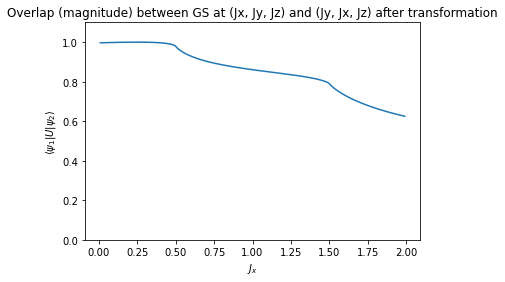

In [108]:
plt.plot(Jx_list, overlap_list, '-')
plt.ylim(bottom=0, top=1.1)
plt.xlabel(r'$J_x$')
plt.ylabel(r'$\langle \psi_1 | U | \psi_2 \rangle$')
plt.title('Overlap (magnitude) between GS at (Jx, Jy, Jz) and (Jy, Jx, Jz) after transformation')

Interesting.
Something weird happened.

In [127]:
psi1 = psi_dict[(1.75, 0.25, 1.0)].copy()
psi2 = psi_dict[(0.25, 1.75, 1.0)].copy()

psi1_transformed = get_transformed_psi(psi1)
psi2_transformed = get_transformed_psi(psi2, theta=-np.pi/2, order_reversed=True)

print(psi1.overlap(psi2_transformed))
print(psi2.overlap(psi1_transformed))

Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=36 for config truncation
Reading 'chi_min'=Non

# SPT Detectors of `X` and `Y`

In [13]:
Jx_list = linspace(0, 2.0, 201)
J_list = [(Jx, np.round(2-Jx, decimals=2), 1.0) for Jx in Jx_list]
    
detector_list = [np.real(detect_SPT_D2(psi_dict[J])) for J in J_list]

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

Text(0.5, 1.0, 'SPT Detector on the line $J_x + J_y = 2 J_z$')

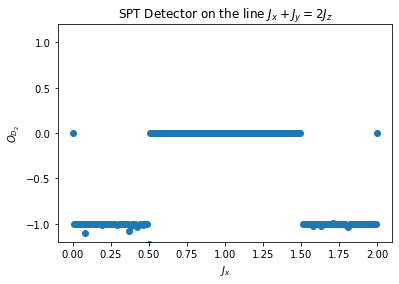

In [14]:
plt.plot(Jx_list, detector_list, 'o')
plt.ylim(-1.2, 1.2)
plt.xlabel(r'$J_x$')
plt.ylabel(r'$O_{D_2}$')
plt.title(r'SPT Detector on the line $J_x + J_y = 2 J_z$')

In [14]:
psi1 = psi_dict[(1.75, 0.25, 1.0)].copy()
psi2 = psi_dict[(0.25, 1.75, 1.0)].copy()
for i in range(psi.L):
    psi1.apply_local_op(i, 'Sigmaz')
psi2.overlap(psi1)

(0.009434093784261632+0.6792746084614397j)

However, for on-site symmetry `X` and `Y` this method might be not so good since the minimum size of repeating unit should be 2-site instead of 4-site.
This implies that it is possible that some hidden information has been discarded by us during the procedure of taking 4 sites together.

To fix this (possibly hidden) issue, we need to calculate the minimum transfer matrix.

In [124]:
import numpy as np
import warnings
import random
from functools import reduce

from tenpy.linalg import np_conserved as npc
from tenpy.linalg import sparse
# from .site import GroupedSite, group_sites
# from ..tools.misc import to_iterable, to_array
# from ..tools.math import lcm, speigs, entropy
# from ..tools.params import asConfig
# from ..algorithms.truncation import TruncationError, svd_theta

In [145]:
class TransferMatrix_Half(sparse.NpcLinearOperator):
    r"""Transfer matrix of two MPS (bra & ket).

    For an iMPS in the thermodynamic limit, we often need to find the 'dominant `RP`' (and `LP`).
    This mean nothing else than to take the transfer matrix of the unit cell and find the
    (right/left) eigenvector with the largest (magnitude) eigenvalue, since it will dominate
    :math:`(TM)^n RP` (or :math:`LP (TM)^n`) in the limit :math:`n \rightarrow \infty` - whatever
    the initial `RP` is. This class provides exactly that functionality with :meth:`eigenvectors`.

    Given two MPS, we define the transfer matrix as::

        |    ---M[i]---M[i+1]- ... --M[i+L]---
        |       |      |             |
        |    ---N[j]*--N[j+1]* ... --N[j+L]*--

    Here the `M` denotes the matrices of the bra and `N` the ones of the ket, respectively.
    To view it as a `matrix`, we combine the left and right indices to pipes::

        |  (vL.vL*) ->-TM->- (vR.vR*)   acting on  (vL.vL*) ->-RP

    Note that we keep all M and N as copies.

    .. deprecated :: 0.6.0
        The default for `shift_ket` was the value of `shift_bra`, this will be changed to 0.

    Parameters
    ----------
    bra : MPS
        The MPS which is to be (complex) conjugated.
    ket : MPS
        The MPS which is not (complex) conjugated.
    shift_bra : int
        We start the `N` of the bra at site `shift_bra` (i.e. the `j` in the above network).
    shift_ket : int | None
        We start the `M` of the ket at site `shift_ket` (i.e. the `i` in the above network).
        ``None`` is deprecated, default will be changed to 0 in the future.
    transpose : bool
        Wheter `self.matvec` acts on `RP` (``False``) or `LP` (``True``).
    charge_sector : None | charges | ``0``
        Selects the charge sector of the vector onto which the Linear operator acts.
        ``None`` stands for *all* sectors, ``0`` stands for the zero-charge sector.
        Defaults to ``0``, i.e., **assumes** the dominant eigenvector is in charge sector 0.
    form : ``'B' | 'A' | 'C' | 'G' | 'Th' | None`` | tuple(float, float)
        In which canonical form we take the `M` and `N` matrices.


    Attributes
    ----------
    L : int
        Number of physical sites involved in the transfer matrix, i.e. the least common multiple
        of `bra.L` and `ket.L`.
    shift_bra : int
        We start the `N` of the bra at site `shift_bra`.
    shift_ket : int | None
        We start the `M` of the ket at site `shift_ket`. ``None`` defaults to `shift_bra`.
    transpose : bool
        Wheter `self.matvec` acts on `RP` (``True``) or `LP` (``False``).
    qtotal : charges
        Total charge of the transfer matrix (which is gauged away in matvec).
    form : tuple(float, float) | None
        In which canonical form (all of) the `M` and `N` matrices are.
    flat_linop : :class:`~tenpy.linalg.sparse.FlatLinearOperator`
        Class lifting :meth:`matvec` to ndarrays in order to use :func:`~tenpy.tools.math.speigs`.
    pipe : :class:`~tenpy.linalg.charges.LegPipe`
        Pipe corresponding to ``'(vL.vL*)'`` for ``transpose=False``
        or to ``'(vR.vR*)'`` for ``transpose=True``.
    label_split :
        ``['vL', 'vL*']`` if ``tranpose=False`` or ``['vR', 'vR*']`` if ``transpose=True``.
    _bra_N : list of npc.Array
        Complex conjugated matrices of the bra, transposed for fast `matvec`.
    _ket_M : list of npc.Array
        The matrices of the ket, transposed for fast `matvec`.
    """
    def __init__(self,
                 bra,
                 ket,
                 shift_bra=0,
                 shift_ket=None,
                 transpose=False,
                 charge_sector=0,
                 form='B'):
        assert bra.L==ket.L
        self.L = L = bra.L//2
        if shift_ket is None:
            if shift_bra != 0:
                warnings.warn("default for shift_ket will change to 0. Specify both explicitly!",
                              FutureWarning, 2)
            shift_ket = shift_bra
        self.shift_bra = shift_bra
        self.shift_ket = shift_ket
        self.transpose = transpose
        if ket.chinfo != bra.chinfo:
            raise ValueError("incompatible charges")
        form = ket._to_valid_form(form)
        self._p_label = p = ket._p_label  # for ususal MPS just ['p']
        assert p == bra._p_label
        self._pstar_label = pstar = ket._get_p_label('*')  # ['p*']
        if not transpose:  # right to left
            label = '(vL.vL*)'  # what we act on
            label_split = ['vL', 'vL*']
            M = self._ket_M = [
                ket.get_B(i, form=form).itranspose(['vL'] + p + ['vR'])
                for i in reversed(range(shift_ket, shift_ket + L))
            ]
            N = self._bra_N = [
                bra.get_B(i, form=form).conj().itranspose(pstar + ['vR*', 'vL*'])
                for i in reversed(range(shift_bra, shift_bra + L))
            ]
            pipe = npc.LegPipe([M[0].get_leg('vR'), N[0].get_leg('vR*')], qconj=-1).conj()
        else:  # left to right
            label = '(vR*.vR)'  # mathematically more natural
            label_split = ['vR*', 'vR']
            M = self._ket_M = [
                ket.get_B(i, form=form).itranspose(['vL'] + p + ['vR'])
                for i in range(shift_ket, shift_ket + L)
            ]
            N = self._bra_N = [
                bra.get_B(i, form=form).conj().itranspose(['vR*', 'vL*'] + pstar)
                for i in range(shift_bra, shift_bra + L)
            ]
            pipe = npc.LegPipe([N[0].get_leg('vL*'), M[0].get_leg('vL')], qconj=+1).conj()
        dtype = np.promote_types(bra.dtype, ket.dtype)
        self.pipe = pipe
        self.label_split = label_split
        self.flat_linop = sparse.FlatLinearOperator(self.matvec, pipe, dtype, charge_sector, label)
        self.qtotal = bra.chinfo.make_valid(np.sum([B.qtotal for B in M + N], axis=0))
        if not ket.finite and np.any(self.qtotal != 0):
            # for non-zero U(1) qtotal, we can immediately say that `self` is nilpotent.
            # In contrast, nonzero Z_N qtotal does not imply that, since the transfer-matrix
            # doesn't have to be hermitian: it could be circulant, with arbitrary eigenvalues!
            # The eigenvectors will *not* conserve the charge in this case!
            enlarge_factors = []
            for i in np.nonzero(self.qtotal)[0]:
                if ket.chinfo.mod[i] == 1:  # U(1) qtotal
                    raise ValueError("TransferMatrix is nil-potent due to charges")
                enlarge_factors.append(ket.chinfo.mod[i])  # get N of Z_N charge

            raise ValueError("TransferMatrix has non-zero qtotal for Z_N charges. "
                             "It can have valid eigenvectors, but they will break the Z_N charge. "
                             "To avoid that, you can enlarge the unit cell of the MPS "
                             "by a factor of " + str(lcm(enlarge_factors)))

    def matvec(self, vec):
        """Given `vec` as an npc.Array, apply the transfer matrix.

        Parameters
        ----------
        vec : :class:`~tenpy.linalg.np_conserved.Array`
            Vector to act on with the transfermatrix.
            If not `transposed`, `vec` is the right part `RP` of an environment,
            with legs ``'(vL.vL*)'`` in a pipe or splitted.
            If `transposed`, the left part `LP` of an environment with legs ``'(vR*.vR)'``.

        Returns
        -------
        mat_vec : :class:`~tenpy.linalg.np_conserved.Array`
            The tranfer matrix acted on `vec`, in the same form as given.
        """
        pipe = None
        if self.label_split[0] not in vec._labels:
            vec = vec.split_legs(0)
            pipe = self.pipe
        # vec.itranspose(self.label_split)  # ['vL', 'vL*'] or ['vR*', 'vR']
        qtotal = vec.qtotal
        legs = vec.legs
        # the actual work
        if not self.transpose:  # right to left
            contract = [self._p_label + ['vL*'], self._pstar_label + ['vR*']]
            for N, M in zip(self._bra_N, self._ket_M):
                vec = npc.tensordot(M, vec, axes=['vR', 'vL'])
                vec = npc.tensordot(vec, N, axes=contract)  # [['p', 'vL*'], ['p*', 'vR*']]
        else:  # left to right
            contract = [['vL*'] + self._pstar_label, ['vR*'] + self._p_label]
            for N, M in zip(self._bra_N, self._ket_M):
                vec = npc.tensordot(vec, M, axes=['vR', 'vL'])
                vec = npc.tensordot(N, vec, axes=contract)  # [['vL*', 'p*'], ['vR*', 'p']])
        if pipe is not None:
            vec = vec.combine_legs(self.label_split, pipes=pipe)
        return vec

    def initial_guess(self, diag=1.):
        """Return a diagonal matrix as initial guess for the eigenvector.

        Parameters
        ----------
        diag : float | 1D ndarray
            Should be ``1.`` for the identity or some singular values squared.

        Returns
        -------
        mat : :class:`~tenpy.linalg.np_conserved.Array`
            A 2D array with `diag` on the diagonal such that :meth:`matvec` can act on it.
        """
        return npc.diag(diag, self.pipe.legs[0], labels=self.label_split)

    def eigenvectors(self,
                     num_ev=1,
                     max_num_ev=None,
                     max_tol=1.e-12,
                     which='LM',
                     v0=None,
                     **kwargs):
        """Find (dominant) eigenvector(s) of self using :mod:`scipy.sparse`.

        If no charge_sector was selected, we look in *all* charge sectors.

        Parameters
        ----------
        num_ev : int
            Number of eigenvalues/vectors to look for.
        max_num_ev : int
            :func:`scipy.sparse.linalg.speigs` somtimes raises a NoConvergenceError for small
            `num_ev`, which might be avoided by increasing `num_ev`. As a work-around,
            we try it again in the case of an error, just with larger `num_ev` up to `max_num_ev`.
            ``None`` defaults to ``num_ev + 2``.
        max_tol : float
            After the first `NoConvergenceError` we increase the `tol` argument to that value.
        which : str
            Which eigenvalues to look for, see `scipy.sparse.linalg.speigs`.
        **kwargs :
            Further keyword arguments given to :func:`~tenpy.tools.math.speigs`.

        Returns
        -------
        eta : 1D ndarray
            The eigenvalues, sorted according to `which`.
        w : list of :class:`~tenpy.linalg.np_conserved.Array`
            The eigenvectors corresponding to `eta`, as npc.Array with LegPipe.
        """
        if max_num_ev is None:
            max_num_ev = num_ev + 2
        flat_linop = self.flat_linop
        if v0 is not None:
            if flat_linop.charge_sector is None:
                raise ValueError("specifying v0 with charge_sector None not supported right now")
            else:
                kwargs['v0'] = self.flat_linop.npc_to_flat(v0)
        # for given charge sector
        for k in range(num_ev, max_num_ev + 1):
            if k > num_ev:
                warnings.warn("TransferMatrix: increased `num_ev` to " + str(k + 1))
            try:
                eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)
                A = np.real_if_close(A)
                if flat_linop.charge_sector is None:
                    convert = flat_linop.flat_to_npc_all_sectors
                else:
                    convert = flat_linop.flat_to_npc
                A = [convert(A[:, j]) for j in range(A.shape[1])]
                break
            except scipy.sparse.linalg.eigen.arpack.ArpackNoConvergence:
                if k == max_num_ev:
                    raise
            # just retry with larger k and 'tol'
            kwargs['tol'] = max(max_tol, kwargs.get('tol', 0))
        # sort
        perm = argsort(eta, which)
        return np.array(eta)[perm], [A[j] for j in perm]

In [149]:
import numpy as np
import warnings
import random
from functools import reduce
import scipy.sparse.linalg.eigen.arpack

from tenpy.linalg import np_conserved as npc
from tenpy.linalg import sparse
# from tenpy.models.site import GroupedSite, group_sites
from tenpy.tools.misc import to_iterable, argsort, to_array
from tenpy.tools.math import lcm, speigs, entropy
from tenpy.tools.params import asConfig
from tenpy.algorithms.truncation import TruncationError, svd_theta

In [169]:
psi = psi_dict[(1.75, 0.25, 1.0)].copy()
psi = psi_dict[(1.0, 1.0, 1.0)].copy()
print("The number of physical spin sites in the wavefunction: ", psi.L)
tm = TransferMatrix_Half(psi, psi)
tm.eigenvectors()

The number of physical spin sites in the wavefunction:  4


(array([1.+8.32667268e-17j]),
 [<npc.Array shape=(2304,) charge=ChargeInfo([], []) labels=['(vL.vL*)']>])

In [173]:
psi = psi_dict[(1.75, 0.25, 1.0)].copy()

op_list = ['Sigmax', 'Sigmay']
U_list = []

for op in op_list:
    # First of all, save a copy of the input wavefunction psi
    psi_copy = psi.copy()
    for i in range(psi_copy.L):
        psi_copy.apply_local_op(i, op)

    TM = TransferMatrix(psi, psi_copy)
    eta, G = TM.eigenvectors(num_ev=1)
    if not np.allclose(np.abs(eta), 1, atol=0.01):
        print("???")

    U = G[0]
    Uop = U.split_legs()
    chi=(Uop.shape[0])
    print("Bond Dimension = ", chi)
    Uop *= np.sqrt(chi) # rescale it
    U_list.append(Uop)

U1 = U_list[0]
U2 = U_list[1]
U12 = npc.tensordot(U1, U2, axes=([1], [0]))
U21 = npc.tensordot(U2, U1, axes=([1], [0]))
npc.inner(U12, U21.conj()) / chi

Bond Dimension =  28
Bond Dimension =  28


/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


(-1.0007192618523486-6.344131569286608e-17j)

In [156]:
psi = psi_dict[(0.25, 1.75, 1.0)].copy()

op_list = ['Sigmax', 'Sigmay']
U_list = []

for op in op_list:
    # First of all, save a copy of the input wavefunction psi
    psi_copy = psi.copy()
    for i in range(psi_copy.L):
        psi_copy.apply_local_op(i, op)

    TM = TransferMatrix(psi, psi_copy)
    eta, G = TM.eigenvectors(num_ev=1)
    if not np.allclose(np.abs(eta), 1, atol=0.01):
        print("???")

    U = G[0]
    Uop = U.split_legs()
    chi=(Uop.shape[0])
    Uop *= np.sqrt(chi) # rescale it
    U_list.append(Uop)

U1 = U_list[0]
U2 = U_list[1]
U12 = npc.tensordot(U1, U2, axes=([1], [0]))
U21 = npc.tensordot(U2, U1, axes=([1], [0]))
npc.inner(U12, U21.conj()) / chi

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


(-1.000707790364026-1.2688263138573217e-16j)

# SPT Detectors of upper `Z` and lower `Z`

In [16]:
Jx_list = linspace(0, 2.0, 201)
J_list = [(Jx, np.round(2-Jx, decimals=2), 1.0) for Jx in Jx_list]
    
detector_list_upper_lower_Z = [np.real(detect_SPT_D2_upper_Z(psi_dict[J])) for J in J_list]

NameError: name 'detect_SPT_D2_upper_Z' is not defined

In [17]:
plt.plot(Jx_list, detector_list_upper_lower_Z, 'o')
plt.ylim(-1.2, 1.2)
plt.xlabel(r'$J_x$')
plt.ylabel(r'$O_{D_2}$')
plt.title(r'SPT Detector on the line $J_x + J_y = 2 J_z, Z_{upper, lower}$')

NameError: name 'detector_list_upper_lower_Z' is not defined

In [21]:
Jx_list = linspace(0, 2.0, 201)
J_list = [(Jx, np.round(2-Jx, decimals=2), 1.0) for Jx in Jx_list]
psi_list = [psi_dict[J].copy() for J in J_list]
    

In [32]:
sym_list = ['Sigmax', 'Sigmay', 'upperSigmaz', 'lowerSigmaz']
sym_U_dict = {}
for sym in sym_list:
    sym_U_dict[sym] = [detect_SPT_onsite(psi, sym) for psi in psi_list]

In [33]:
sym_U_dict['Sigmaz'] = [detect_SPT_onsite(psi, 'Sigmaz') for psi in psi_list]

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'The commutator between Sigmax and Sigmaz')

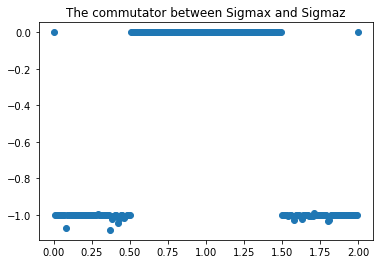

In [34]:
sym1 = 'Sigmax'
sym2 = 'Sigmaz'

sym_list_1 = sym_U_dict[sym1]
sym_list_2 = sym_U_dict[sym2]

commutator_list = []
for J in range(len(J_list)):
    if sym_list_1[J] == 0 or sym_list_2[J] == 0:
        commutator_list.append(0)
    else:
#         print(sym_list_1[J])
        chi = sym_list_1[J][1]
        U1 = sym_list_1[J][0]
        U2 = sym_list_2[J][0]
        U12 = npc.tensordot(U1, U2, axes=([1], [0]))
        U21 = npc.tensordot(U2, U1, axes=([1], [0]))
        commutator_list.append(npc.inner(U12, U21.conj()) / chi)
plt.plot(Jx_list, commutator_list, 'o')
plt.title("The commutator between "+sym1+" and "+sym2)

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


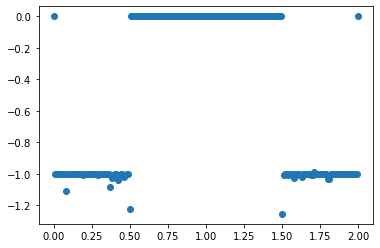

In [35]:
sym1 = 'Sigmax'
sym2 = 'Sigmay'

sym_list_1 = sym_U_dict[sym1]
sym_list_2 = sym_U_dict[sym2]

commutator_list = []
for J in range(len(J_list)):
    if sym_list_1[J] == 0 or sym_list_2[J] == 0:
        commutator_list.append(0)
    else:
#         print(sym_list_1[J])
        chi = sym_list_1[J][1]
        U1 = sym_list_1[J][0]
        U2 = sym_list_2[J][0]
        U12 = npc.tensordot(U1, U2, axes=([1], [0]))
        U21 = npc.tensordot(U2, U1, axes=([1], [0]))
        commutator_list.append(npc.inner(U12, U21.conj()) / chi)
plt.plot(Jx_list, commutator_list, 'o')

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


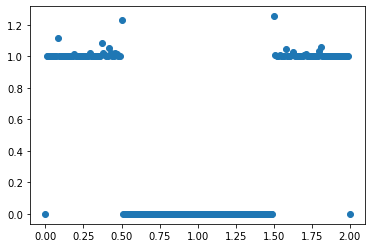

In [36]:
sym1 = 'Sigmax'
sym2 = 'lowerSigmaz'

sym_list_1 = sym_U_dict[sym1]
sym_list_2 = sym_U_dict[sym2]

commutator_list = []
for J in range(len(J_list)):
    if sym_list_1[J] == 0 or sym_list_2[J] == 0:
        commutator_list.append(0)
    else:
#         print(sym_list_1[J])
        chi = sym_list_1[J][1]
        U1 = sym_list_1[J][0]
        U2 = sym_list_2[J][0]
        U12 = npc.tensordot(U1, U2, axes=([1], [0]))
        U21 = npc.tensordot(U2, U1, axes=([1], [0]))
        commutator_list.append(npc.inner(U12, U21.conj()) / chi)
plt.plot(Jx_list, commutator_list, 'o')

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


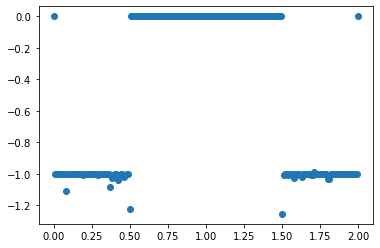

In [37]:
sym1 = 'upperSigmaz'
sym2 = 'lowerSigmaz'

sym_list_1 = sym_U_dict[sym1]
sym_list_2 = sym_U_dict[sym2]

commutator_list = []
for J in range(len(J_list)):
    if sym_list_1[J] == 0 or sym_list_2[J] == 0:
        commutator_list.append(0)
    else:
#         print(sym_list_1[J])
        chi = sym_list_1[J][1]
        U1 = sym_list_1[J][0]
        U2 = sym_list_2[J][0]
        U12 = npc.tensordot(U1, U2, axes=([1], [0]))
        U21 = npc.tensordot(U2, U1, axes=([1], [0]))
        commutator_list.append(npc.inner(U12, U21.conj()) / chi)
plt.plot(Jx_list, commutator_list, 'o')

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


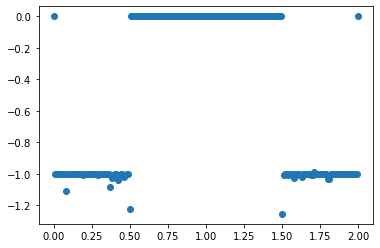

In [38]:
sym1 = 'Sigmax'
sym2 = 'upperSigmaz'

sym_list_1 = sym_U_dict[sym1]
sym_list_2 = sym_U_dict[sym2]

commutator_list = []
for J in range(len(J_list)):
    if sym_list_1[J] == 0 or sym_list_2[J] == 0:
        commutator_list.append(0)
    else:
#         print(sym_list_1[J])
        chi = sym_list_1[J][1]
        U1 = sym_list_1[J][0]
        U2 = sym_list_2[J][0]
        U12 = npc.tensordot(U1, U2, axes=([1], [0]))
        U21 = npc.tensordot(U2, U1, axes=([1], [0]))
        commutator_list.append(npc.inner(U12, U21.conj()) / chi)
plt.plot(Jx_list, commutator_list, 'o')

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


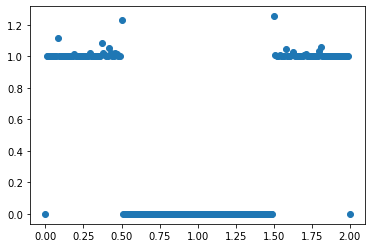

In [39]:
sym1 = 'Sigmax'
sym2 = 'lowerSigmaz'

sym_list_1 = sym_U_dict[sym1]
sym_list_2 = sym_U_dict[sym2]

commutator_list = []
for J in range(len(J_list)):
    if sym_list_1[J] == 0 or sym_list_2[J] == 0:
        commutator_list.append(0)
    else:
#         print(sym_list_1[J])
        chi = sym_list_1[J][1]
        U1 = sym_list_1[J][0]
        U2 = sym_list_2[J][0]
        U12 = npc.tensordot(U1, U2, axes=([1], [0]))
        U21 = npc.tensordot(U2, U1, axes=([1], [0]))
        commutator_list.append(npc.inner(U12, U21.conj()) / chi)
plt.plot(Jx_list, commutator_list, 'o')

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


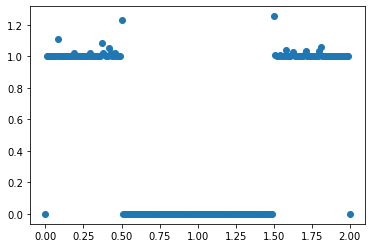

In [40]:
sym1 = 'upperSigmaz'
sym2 = 'Sigmay'

sym_list_1 = sym_U_dict[sym1]
sym_list_2 = sym_U_dict[sym2]

commutator_list = []
for J in range(len(J_list)):
    if sym_list_1[J] == 0 or sym_list_2[J] == 0:
        commutator_list.append(0)
    else:
#         print(sym_list_1[J])
        chi = sym_list_1[J][1]
        U1 = sym_list_1[J][0]
        U2 = sym_list_2[J][0]
        U12 = npc.tensordot(U1, U2, axes=([1], [0]))
        U21 = npc.tensordot(U2, U1, axes=([1], [0]))
        commutator_list.append(npc.inner(U12, U21.conj()) / chi)
plt.plot(Jx_list, commutator_list, 'o')

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


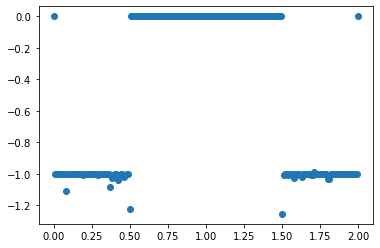

In [41]:
sym1 = 'lowerSigmaz'
sym2 = 'Sigmay'

sym_list_1 = sym_U_dict[sym1]
sym_list_2 = sym_U_dict[sym2]

commutator_list = []
for J in range(len(J_list)):
    if sym_list_1[J] == 0 or sym_list_2[J] == 0:
        commutator_list.append(0)
    else:
#         print(sym_list_1[J])
        chi = sym_list_1[J][1]
        U1 = sym_list_1[J][0]
        U2 = sym_list_2[J][0]
        U12 = npc.tensordot(U1, U2, axes=([1], [0]))
        U21 = npc.tensordot(U2, U1, axes=([1], [0]))
        commutator_list.append(npc.inner(U12, U21.conj()) / chi)
plt.plot(Jx_list, commutator_list, 'o')

In [127]:
psi = psi_dict[(1.75, 0.25, 1.0)].copy()
psi.finite
psi.chinfo

ChargeInfo([], [])

# SPT Detectors of Spatial Inversion

In [60]:
Jx_list = linspace(0, 2.0, 201)
J_list = [(Jx, np.round(2-Jx, decimals=2), 1.0) for Jx in Jx_list]
    
detector_list_spatial_inv = [np.real(detect_SPT_spatial_inv(psi_dict[J])) for J in J_list]

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

Text(0.5, 1.0, 'SPT Detector on the line $J_x + J_y = 2 J_z, Z_{upper, lower}$')

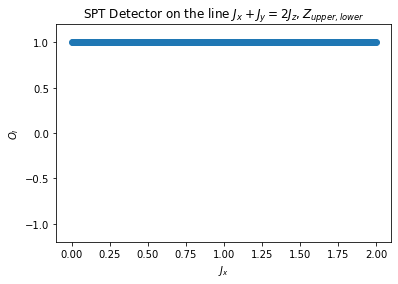

In [61]:
plt.plot(Jx_list, detector_list_spatial_inv, 'o')
plt.ylim(-1.2, 1.2)
plt.xlabel(r'$J_x$')
plt.ylabel(r'$O_{I}$')
plt.title(r'SPT Detector on the line $J_x + J_y = 2 J_z, Space Inversion$')

# SPT Detectors of Time Reversal

In [72]:
Jx_list = linspace(0, 2.0, 201)
J_list = [(Jx, np.round(2-Jx, decimals=2), 1.0) for Jx in Jx_list]
    
detector_list_time_rev = [np.real(detect_SPT_spatial_inv(psi_dict[J], Op='time_reversal')) for J in J_list]

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

Text(0.5, 1.0, 'SPT Detector on the line $J_x + J_y = 2 J_z, Time Reversal$')

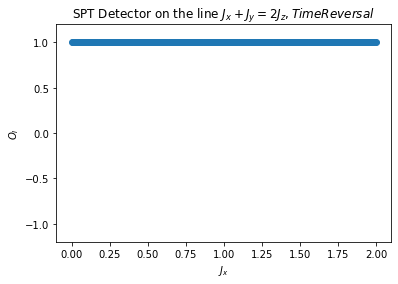

In [74]:
plt.plot(Jx_list, detector_list_time_rev, 'o')
plt.ylim(-1.2, 1.2)
plt.xlabel(r'$J_x$')
plt.ylabel(r'$O_{I}$')
plt.title(r'SPT Detector on the line $J_x + J_y = 2 J_z, Time Reversal$')

Let's have a look at some other symmetries.

First of all, the global `Z` will be automatically symmetrized since it's simply the product of `X` and `Y`.

Then we still have to consider the upper `Z` and lower `Z`; similarly, we only need to consider one of them.
Say, 
$$\Sigma^z_{upper} = \prod_{n=1}^{N} \sigma^z_{4k+1} \sigma^z_{4k+4}$$

# Translational Invariance Checking

In [85]:
def check_TI(psi, d=2):
    psi_copy = psi.copy()
    tm = TransferMatrix(psi_copy, psi_copy, shift_bra=d, shift_ket=0)
    tm_eigs = tm.eigenvectors(num_ev=2)[0] # get the first two eigenvalues
    return tm_eigs

In [ ]:
Jx_list = linspace(0, 2.0, 201)
J_list = [(Jx, np.round(2-Jx, decimals=2), 1.0) for Jx in Jx_list]
psi_list = [psi_dict[J].copy() for J in J_list]

for psi in psi_list:
    assert psi.L == 4
largest_eig_list = [np.abs(check_TI(psi)[0]) for psi in psi_list]
second_eig_list = [np.abs(check_TI(psi)[1]) for psi in psi_list]

In [86]:
four_shifted_list = [np.abs(check_TI(psi, d=4)[0]) for psi in psi_list]

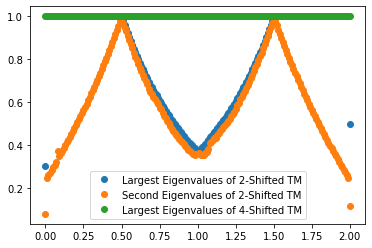

In [87]:
plt.plot(Jx_list, largest_eig_list, 'o', label='Largest Eigenvalues of 2-Shifted TM')
plt.plot(Jx_list, second_eig_list, 'o', label='Second Eigenvalues of 2-Shifted TM')
plt.plot(Jx_list, four_shifted_list, 'o', label='Largest Eigenvalues of 4-Shifted TM')
plt.legend()
plt.show()
# detector_list_time_rev = [np.real(detect_SPT_spatial_inv(psi_dict[J], Op='time_reversal')) for J in J_list]

In [57]:
global_list = []
upper_list = []
lower_list = []
global_X_list = []
global_Y_list = []
Jx_list = []

for J, psi in psi_dict.items():
    Jx_list.append(J[0])
    psi_copy = psi.copy()
    M = psi.L
    assert M%4==0
    N = M // 4 # extract the total number of unitcells
    
    for n in range(N): # loop over each unicell
        i = 4*n
        psi_copy.apply_local_op(i, 'Sigmaz')
        i = 4*n+3
        psi_copy.apply_local_op(i, 'Sigmaz')
        pass
    
    upper_list.append(np.abs(psi.overlap(psi_copy)))
    
    
    psi_copy = psi.copy()
    for n in range(N):
        i = 4*n+1
        psi_copy.apply_local_op(i, 'Sigmaz')
        i = 4*n+2
        psi_copy.apply_local_op(i, 'Sigmaz')
        pass
    
    lower_list.append(np.abs(psi.overlap(psi_copy)))
    
    
    psi_copy = psi.copy()
    for n in range(4*N):
        psi_copy.apply_local_op(n, 'Sigmaz')
        pass
    
    global_list.append(np.abs(psi.overlap(psi_copy)))
    
    
    psi_copy = psi.copy()
    for n in range(4*N):
        psi_copy.apply_local_op(n, 'Sigmax')
        pass
    
    global_X_list.append(np.abs(psi.overlap(psi_copy)))
    
    
    psi_copy = psi.copy()
    for n in range(4*N):
        psi_copy.apply_local_op(n, 'Sigmay')
        pass
    
    global_Y_list.append(np.abs(psi.overlap(psi_copy)))

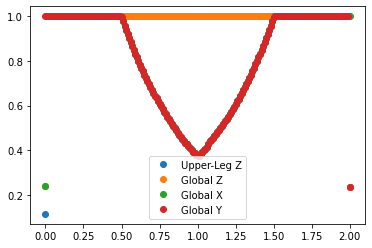

In [62]:
plt.plot(Jx_list[1:], upper_list[1:], 'o', label='Upper-Leg Z')
# plt.plot(Jx_list, lower_list, 'o', label='Lower-Leg Z')
plt.plot(Jx_list[1:], global_list[1:], 'o', label='Global Z')
plt.plot(Jx_list[1:], global_X_list[1:], 'o', label='Global X')
plt.plot(Jx_list[1:], global_Y_list[1:], 'o', label='Global Y')
plt.legend()

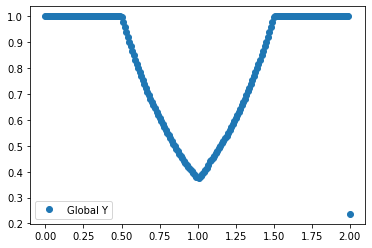

In [63]:
plt.plot(Jx_list[1:], global_Y_list[1:], 'o', label='Global Y')
plt.legend()

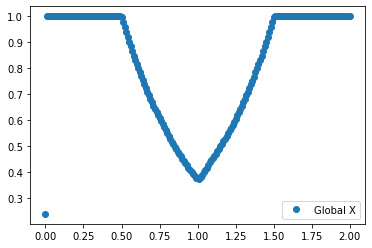

In [64]:
upperplt.plot(Jx_list[1:], global_X_list[1:], 'o', label='Global X')
plt.legend()

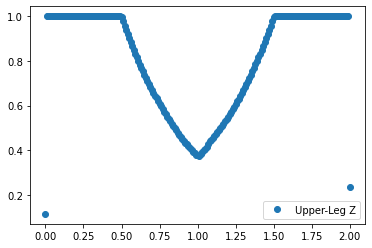

In [65]:
plt.plot(Jx_list[1:], upper_list[1:], 'o', label='Upper-Leg Z')
plt.legend()

The initial point 111 seems to be wrong and considering the fact that it is the first point we need to redo its simulation.

In [48]:
chi_list = [4, 8, 16, 32, 64, 128]

Jx = 1.0
Jy = 1.0
Jz = 1.0
L = 2
chi = 64

psi_list = []
result_list = []

initial_psi = None
for chi in chi_list:
    result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi, initial_psi=initial_psi, bc='periodic', bc_MPS='infinite')
    psi = result['psi'].copy()
    psi_list.append(psi)
    initial_psi = psi.copy()

Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  4 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True f

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8388027275038041, S = nan, norm_err = 6.5e-07
Current memory usage 327.6 MB, time elapsed: 1.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4532e-07, max_E_trunc = 2.8254e-06
MPS bond dimensions: [8, 8, 8, 8]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8388029009164057, S = nan, norm_err = 1.1e-07
Current memory usage 327.6 MB, time elapsed: 3.4 s
Delta E = -1.7341e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.5350e-07, max_E_trunc = 2.8068e-06
MPS bond dimensions: [8, 8, 8, 8]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8388049833879485, S = nan, norm_err = 1.6e-09
Current memory usage 327.6 MB, time elapsed: 2.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3535e-10, max_E_trunc = 2.1083e-09
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8388049847890713, S = nan, norm_err = 4.1e-10
Current memory usage 327.6 MB, time elapsed: 4.2 s
Delta E = -1.4011e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3205e-10, max_E_trunc = 2.0256e-09
MPS bond dimensions: [16, 16, 16, 16]
Convergence criterium reached with 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8388049859311444, S = nan, norm_err = 6.1e-13
Current memory usage 327.6 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.2947e-18, max_E_trunc = 8.5265e-14
MPS bond dimensions: [54, 57, 33, 58]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8388049859312261, S = nan, norm_err = 5.7e-13
Current memory usage 327.6 MB, time elapsed: 7.1 s
Delta E = -8.1712e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0529e-18, max_E_trunc = 2.2737e-13
MPS bond dimensions: [46, 56, 35, 57]
Convergence criterium reached w

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8388049859311160, S = nan, norm_err = 6.9e-13
Current memory usage 327.6 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2023e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [52, 58, 35, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8388049859312190, S = nan, norm_err = 6.3e-13
Current memory usage 327.6 MB, time elapsed: 8.7 s
Delta E = -1.0303e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1920e-19, max_E_trunc = -1.7053e-13
MPS bond dimensions: [47, 56, 35, 58]
Convergence criterium reached

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


In [49]:
psi_copy = psi.copy()
for i in range(psi.L):
    psi_copy.apply_local_op(i, 'Sigmaz')
    
np.abs(psi.overlap(psi_copy))

1.0000000000000064

In [50]:
psi_copy = psi.copy()
for i in range(psi.L // 4):
    psi_copy.apply_local_op(4*i, 'Sigmaz')
    psi_copy.apply_local_op(4*i+3, 'Sigmaz')
    
np.abs(psi.overlap(psi_copy))

0.37190462246877415

In [98]:
for x in x_list:
    x = float(x)
    
for y in y_list:
    y = float(y)
    
for z in z_list:
    z = float(z)

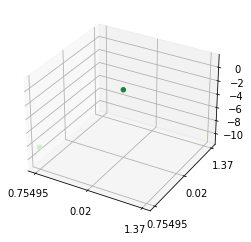

In [101]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_list, y_list, z_list, c=z_list, cmap='Greens')

In [108]:
from kitaev_ladder_snake1 import run_atomic

In [120]:
Jx_list = linspace(1.0, 2.0, 11)

Jz = 1.0
L = 2
chi = 64

psi_list = []
result_list = []

initial_psi = None
for Jx in Jx_list:
    Jy = np.round(2 - Jx, decimals=2)
#     print(Jy)
    result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi, initial_psi=initial_psi, bc='periodic', bc_MPS='infinite')
    psi = result['psi'].copy()
    psi_list.append(psi)
    initial_psi = psi.copy()
    result_list.append(detect_SPT_D2(psi))

Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999996-6.938893903907228e-17j)
After the canonicalization:
Bond dim =  [48, 64, 48, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.1 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.9 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environmen

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8400658916211938, S = nan, norm_err = 4.3e-13
Current memory usage 342.8 MB, time elapsed: 2.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8248e-18, max_E_trunc = 1.1369e-13
MPS bond dimensions: [51, 58, 34, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8400658916212365, S = nan, norm_err = 3.3e-13
Current memory usage 342.8 MB, time elapsed: 5.9 s
Delta E = -4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5736e-18, max_E_trunc = 3.9790e-13
MPS bond dimensions: [47, 55, 33, 56]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [28, 40, 28, 40]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999987-1.3877787807814457e-17j)
After the canonicalization:
Bond dim =  [28, 40, 28, 40]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.2 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.8 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swee

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8439663883084556, S = nan, norm_err = 9.3e-12
Current memory usage 342.8 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7327e-17, max_E_trunc = 2.2737e-13
MPS bond dimensions: [56, 64, 43, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8439663883084521, S = nan, norm_err = 1.6e-12
Current memory usage 342.8 MB, time elapsed: 7.4 s
Delta E = 3.5527e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8189e-17, max_E_trunc = 4.5475e-13
MPS bond dimensions: [52, 64, 37, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999984+3.599600057667046e-16j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.3 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.7 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environmen

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8509040344471295, S = nan, norm_err = 4.7e-09
Current memory usage 342.8 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5393e-16, max_E_trunc = 1.9895e-13
MPS bond dimensions: [64, 64, 43, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8509040344471757, S = nan, norm_err = 4.2e-13
Current memory usage 342.8 MB, time elapsed: 6.8 s
Delta E = -4.6185e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3963e-16, max_E_trunc = 4.8317e-13
MPS bond dimensions: [59, 64, 44, 64]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000001-3.334615456761526e-16j)
After the canonicalization:
Bond dim =  [33, 46, 33, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.4 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.6 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8617441953762963, S = nan, norm_err = 2.9e-06
Current memory usage 342.8 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.9972e-16, max_E_trunc = 1.1369e-13
MPS bond dimensions: [64, 64, 46, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8617441955757670, S = nan, norm_err = 3.2e-09
Current memory usage 342.8 MB, time elapsed: 7.1 s
Delta E = -1.9947e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4166e-15, max_E_trunc = 4.2633e-13
MPS bond dimensions: [64, 64, 52, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [43, 60, 43, 60]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999989-7.025304024636299e-17j)
After the canonicalization:
Bond dim =  [43, 60, 43, 60]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.5 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweep

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8786254625676051, S = nan, norm_err = 1.5e-03
Current memory usage 342.8 MB, time elapsed: 4.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.2893e-14, max_E_trunc = 1.0232e-12
MPS bond dimensions: [64, 64, 55, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8786388365559858, S = nan, norm_err = 9.1e-04
Current memory usage 342.8 MB, time elapsed: 10.7 s
Delta E = -1.3374e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6710e-12, max_E_trunc = 9.2086e-12
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep

norm_tol=1.00e-05 not reached, norm_err=1.01e-04
Updating environment
..

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 8.64e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2684, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000007-4.810605039318183e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.6 for config KitaevLadderSnakeCompactModel


/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9060804016843349, S = nan, norm_err = 1.7e-04
Current memory usage 342.8 MB, time elapsed: 4.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8465e-14, max_E_trunc = 3.9790e-13
MPS bond dimensions: [64, 64, 57, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9060804337593993, S = nan, norm_err = 7.6e-06
Current memory usage 342.8 MB, time elapsed: 8.2 s
Delta E = -3.2075e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4445e-14, max_E_trunc = 6.8212e-13
MPS bond dimensions: [64, 64, 58, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [50, 64, 50, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999996-4.07394510453941e-16j)
After the canonicalization:
Bond dim =  [50, 64, 50, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.7 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.3 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9400028937027756, S = nan, norm_err = 9.0e-11
Current memory usage 342.8 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4915e-16, max_E_trunc = 8.5265e-14
MPS bond dimensions: [64, 64, 50, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9400028937027258, S = nan, norm_err = 7.9e-13
Current memory usage 342.8 MB, time elapsed: 6.8 s
Delta E = 4.9738e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0927e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [64, 64, 45, 64]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000016-7.308537974461399e-17j)
After the canonicalization:
Bond dim =  [38, 44, 38, 44]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.8 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.2 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environmen

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9781997801631661, S = nan, norm_err = 2.4e-12
Current memory usage 342.8 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4406e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [49, 54, 38, 56]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9781997801630666, S = nan, norm_err = 1.8e-13
Current memory usage 342.8 MB, time elapsed: 7.3 s
Delta E = 9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4093e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [48, 49, 35, 59]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999993+1.3408629295495507e-16j)
After the canonicalization:
Bond dim =  [28, 34, 28, 34]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.9 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.1 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0196051343590540, S = nan, norm_err = 4.9e-13
Current memory usage 342.8 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9745e-20, max_E_trunc = 8.5265e-14
MPS bond dimensions: [41, 41, 26, 41]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0196051343591037, S = nan, norm_err = 4.0e-13
Current memory usage 342.8 MB, time elapsed: 6.8 s
Delta E = -4.9738e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.3056e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [39, 40, 30, 41]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000089+1.6584848780594787e-16j)
After the canonicalization:
Bond dim =  [20, 26, 20, 26]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=2.0 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0635444099734102, S = nan, norm_err = 6.9e-14
Current memory usage 342.8 MB, time elapsed: 2.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9894e-20, max_E_trunc = 3.1264e-13
MPS bond dimensions: [17, 12, 15, 14]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0635444099734883, S = nan, norm_err = 5.3e-15
Current memory usage 342.8 MB, time elapsed: 4.9 s
Delta E = -7.8160e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2557e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [15, 11, 17, 12]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


In [139]:
result_list = [np.real(detect_SPT_D2(psi)) for psi in psi_list]

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

Text(0.5, 1.0, 'SPT Detection $O_{D_2}:= \\frac{1}{\\chi} tr(U_x U_y U_x^\\dagger U_y^\\dagger), J_x+J_y = 2J_z$')

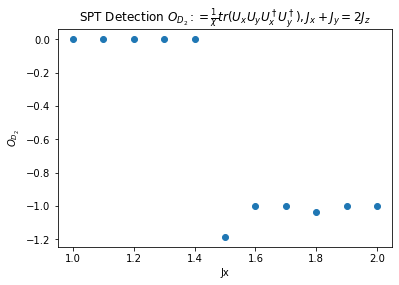

In [148]:
plt.plot(Jx_list, result_list, 'o')
plt.xlabel('Jx')
plt.ylabel(r'$O_{D_2}$')
plt.title(r'SPT Detection $O_{D_2}:= \frac{1}{\chi} tr(U_x U_y U_x^\dagger U_y^\dagger), J_x+J_y = 2J_z$')

In [130]:
psi0 = psi_list[1]

In [131]:
psi = psi0

op_list = ['Sigmax', 'Sigmay']
U_list = []

for op in op_list:
    # First of all, save a copy of the input wavefunction psi
    psi_copy = psi.copy()
    for i in range(psi_copy.L):
        psi_copy.apply_local_op(i, op)

    TM = TransferMatrix(psi, psi_copy)
    eta, G = TM.eigenvectors(num_ev=1)
#         if not np.allclose(eta, 1):
#             print(f'eta={eta}')
#             raise ValueError('The largest eigenvalue of the transfer matrix is not 1!')
    print(eta)
    print(np.abs(eta))

    U = G[0]
    Uop = U.split_legs()
    chi=(Uop.shape[0])
    Uop *= np.sqrt(chi) # rescale it
    U_list.append(Uop)

U1 = U_list[0]
U2 = U_list[1]
U12 = npc.tensordot(U1, U2, axes=([1], [0]))
U21 = npc.tensordot(U2, U1, axes=([1], [0]))

print(npc.inner(U12, U21.conj()) / chi)

[0.45458308-4.37791096e-17j]
[0.45458308]
[0.45458308+8.61609273e-16j]
[0.45458308]
(-9.976148222050618+2.0301221021717147e-15j)


/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


In [155]:
def get_detector_list(chi=128, num=101):
    Jx_list = linspace(1.0, 2.0, num)

    Jz = 1.0
    L = 2
#     chi = 128

    psi_list = []
    result_list = []

    initial_psi = None
    for Jx in Jx_list:
        Jy = np.round(2 - Jx, decimals=2)
    #     print(Jy)
        result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi, initial_psi=initial_psi, bc='periodic', bc_MPS='infinite')
        psi = result['psi'].copy()
        psi_list.append(psi)
        initial_psi = psi.copy()
        result_list.append(detect_SPT_D2(psi))
    return (Jx_list, result_list)

Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [34, 35, 30, 34]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.0004858254618897833+4.404571325722362e-20j)
After the canonicalization:
Bond dim =  [34, 35, 30, 34]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.01 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.99 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000078-5.225346251611779e-17j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.02 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.98 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000004+5.778797579347739e-17j)
After the canonicalization:
Bond dim =  [27, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.03 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.97 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000024-5.898059818321144e-17j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.04 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.96 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000006+6.083560033769836e-17j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.05 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.95 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999996+2.946861504815601e-16j)
After the canonicalization:
Bond dim =  [28, 38, 28, 39]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.06 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.94 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999949+8.998878031629687e-18j)
After the canonicalization:
Bond dim =  [28, 39, 29, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.07 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.93 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000016-2.255140518769849e-16j)
After the canonicalization:
Bond dim =  [28, 41, 28, 40]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.08 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.92 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000084+5.4014364604120673e-17j)
After the canonicalization:
Bond dim =  [28, 41, 28, 40]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.09 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.91 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000049-6.519130845027599e-17j)
After the canonicalization:
Bond dim =  [28, 40, 28, 40]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.1 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.9 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environmen

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000042-2.7449404968932006e-16j)
After the canonicalization:
Bond dim =  [28, 40, 28, 40]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.11 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.89 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000018+6.519932565020897e-16j)
After the canonicalization:
Bond dim =  [28, 40, 28, 40]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.12 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.88 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999951+3.232947337700078e-16j)
After the canonicalization:
Bond dim =  [28, 40, 28, 40]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.13 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.87 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999993-3.386877783208571e-18j)
After the canonicalization:
Bond dim =  [29, 40, 28, 40]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.14 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.86 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000044+3.2959746043559335e-16j)
After the canonicalization:
Bond dim =  [29, 40, 28, 39]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.15 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.85 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.999999999999998+2.4136324269508476e-16j)
After the canonicalization:
Bond dim =  [29, 39, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.16 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.84 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000003-1.1663552238874998e-16j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.17 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.83 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000005-1.232941852855074e-16j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.18 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.82 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000002+8.941903319962137e-17j)
After the canonicalization:
Bond dim =  [29, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.19 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.81 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1+1.5034231964533402e-16j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.2 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.8 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Rea

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000053-1.5044479243397832e-16j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.21 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.79 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000029+2.2757025744366924e-17j)
After the canonicalization:
Bond dim =  [28, 39, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.22 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.78 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000069+3.1715168563627916e-16j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.23 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.77 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [31, 41, 30, 41]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000058-1.0288564275982552e-17j)
After the canonicalization:
Bond dim =  [31, 41, 30, 41]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.24 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.76 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sw

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000029+2.913655530264742e-16j)
After the canonicalization:
Bond dim =  [32, 40, 31, 40]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.25 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.75 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000042-1.0828247637371903e-16j)
After the canonicalization:
Bond dim =  [33, 40, 31, 40]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.26 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.74 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000042+1.3183898417423734e-16j)
After the canonicalization:
Bond dim =  [33, 46, 33, 45]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.27 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.73 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000036+4.790412826987726e-17j)
After the canonicalization:
Bond dim =  [33, 46, 33, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.28 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.72 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [33, 46, 33, 46]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999964+2.2703049127362458e-17j)
After the canonicalization:
Bond dim =  [33, 46, 33, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.29 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.71 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sw

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [33, 46, 33, 46]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999991+1.4978984951932145e-16j)
After the canonicalization:
Bond dim =  [33, 46, 33, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.3 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.7 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swee

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000073-1.8309456784824812e-17j)
After the canonicalization:
Bond dim =  [33, 46, 33, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.31 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.69 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000042-1.7633540626330558e-16j)
After the canonicalization:
Bond dim =  [33, 46, 33, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.32 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.68 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999998-2.9422850193658127e-17j)
After the canonicalization:
Bond dim =  [33, 46, 33, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.33 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.67 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1-1.0049373816829998e-16j)
After the canonicalization:
Bond dim =  [36, 46, 36, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.34 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.66 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
R

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000007-2.1268513915261114e-16j)
After the canonicalization:
Bond dim =  [38, 46, 38, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.35 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.65 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000069+7.05140764381373e-17j)
After the canonicalization:
Bond dim =  [38, 46, 38, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.36 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.64 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000033+4.3202468320576606e-16j)
After the canonicalization:
Bond dim =  [38, 49, 38, 47]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.37 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.63 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999916-2.3447303829639363e-17j)
After the canonicalization:
Bond dim =  [38, 54, 38, 55]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.38 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.62 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [40, 60, 40, 60]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999996+1.9676343836863943e-16j)
After the canonicalization:
Bond dim =  [40, 60, 40, 60]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.39 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.61 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sw

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999986+2.498001805406602e-16j)
After the canonicalization:
Bond dim =  [43, 60, 42, 60]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.4 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.6 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environmen

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000038+4.103155849965234e-17j)
After the canonicalization:
Bond dim =  [43, 60, 43, 60]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.41 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.59 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000008+3.2771101383730084e-16j)
After the canonicalization:
Bond dim =  [43, 60, 43, 60]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.42 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.58 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [47, 60, 46, 59]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000002-1.0083372673207805e-16j)
After the canonicalization:
Bond dim =  [47, 60, 46, 59]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.43 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.57 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999984-9.578978699198813e-17j)
After the canonicalization:
Bond dim =  [48, 64, 48, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.44 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.56 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [52, 64, 52, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000009+9.71445146547012e-17j)
After the canonicalization:
Bond dim =  [52, 64, 52, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.45 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.55 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swee

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [53, 64, 53, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999913-1.2662677386094563e-16j)
After the canonicalization:
Bond dim =  [53, 64, 53, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.46 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.54 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sw

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [58, 64, 58, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999996+4.85722573273506e-17j)
After the canonicalization:
Bond dim =  [58, 64, 58, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.47 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.53 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swee

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [61, 64, 61, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000002+1.734723475976807e-17j)
After the canonicalization:
Bond dim =  [61, 64, 61, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.48 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.52 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swee

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [62, 64, 62, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000002+2.7712207528729493e-16j)
After the canonicalization:
Bond dim =  [62, 64, 62, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.49 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.51 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
DMRG finished after 50 sweeps.
total size = 724, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000006-1.8302429843919805e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.5 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<

Updating environment
.....
sweep 170, age = 2124
Energy = -0.8786452989438089, S = 0.9655656789849156, norm_err = 1.2e-04
Current memory usage 381.4 MB, time elapsed: 47.5 s
Delta E = -1.3303e-09, Delta S = 4.4627e-04 (per sweep)
max_trunc_err = 2.8346e-10, max_E_trunc = 3.1846e-09
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 2244
Energy = -0.8786453108303363, S = 0.9698992826302061, norm_err = 1.1e-04
Current memory usage 381.4 MB, time elapsed: 49.5 s
Delta E = -1.1887e-09, Delta S = 4.3336e-04 (per sweep)
max_trunc_err = 3.0563e-10, max_E_trunc = 3.3458e-09
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 190, age = 2364
Energy = -0.8786453208152807, S = 0.9740415840398878, norm_err = 1.0e-04
Current memory usage 381.4 MB, time elapsed: 51.3 s
Delta E = -9.9849e-10, Delta S = 4.1423e-04 (per sweep)
max_trunc_err = 2.8453e-10, max_E_trunc = 2.7123e-09
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 200,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 8.30e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2684, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999986+3.2240036457587594e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.51 for config KitaevLadderSnakeCompactMode

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8809249441739979, S = nan, norm_err = 1.5e-03
Current memory usage 381.4 MB, time elapsed: 4.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8506e-12, max_E_trunc = 1.2221e-11
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8809330225627434, S = nan, norm_err = 2.0e-03
Current memory usage 381.4 MB, time elapsed: 10.2 s
Delta E = -8.0784e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6793e-11, max_E_trunc = 8.8903e-11
MPS bond dimensions: [64, 64, 64, 64]
Convergence criterium reached wi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.91e-04
Call psi.canonical_form()
DMRG finished after 100 sweeps.
total size = 1484, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000006-1.0605875556605446e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.52 for config KitaevLadderSnakeCompactModel

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8833779542636080, S = nan, norm_err = 2.5e-04
Current memory usage 381.4 MB, time elapsed: 4.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0364e-12, max_E_trunc = 1.3387e-11
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8833786288837615, S = nan, norm_err = 4.6e-05
Current memory usage 381.4 MB, time elapsed: 9.2 s
Delta E = -6.7462e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4465e-11, max_E_trunc = 8.1997e-11
MPS bond dimensions: [64, 64, 64, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.61e-05
Call psi.canonical_form()
DMRG finished after 40 sweeps.
total size = 764, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000005-8.091971435533083e-17j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.53 for config KitaevLadderSnakeCompactModel
Re

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8859229544920062, S = nan, norm_err = 1.3e-04
Current memory usage 381.4 MB, time elapsed: 4.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0507e-12, max_E_trunc = 7.0202e-12
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8859231604989262, S = nan, norm_err = 1.1e-05
Current memory usage 381.4 MB, time elapsed: 8.1 s
Delta E = -2.0601e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3369e-12, max_E_trunc = 2.7200e-11
MPS bond dimensions: [64, 64, 64, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG finished after 40 sweeps.
total size = 764, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000007-1.3577387101642393e-17j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.54 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.46 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel




/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8885651969703012, S = nan, norm_err = 6.3e-05
Current memory usage 381.4 MB, time elapsed: 4.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9505e-13, max_E_trunc = 3.8654e-12
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8885652542891620, S = nan, norm_err = 2.8e-06
Current memory usage 381.4 MB, time elapsed: 7.8 s
Delta E = -5.7319e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3630e-12, max_E_trunc = 1.1397e-11
MPS bond dimensions: [64, 64, 64, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8912960174741507, S = nan, norm_err = 3.0e-05
Current memory usage 381.4 MB, time elapsed: 4.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4774e-13, max_E_trunc = 2.7285e-12
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8912960328820958, S = nan, norm_err = 6.9e-07
Current memory usage 381.4 MB, time elapsed: 7.5 s
Delta E = -1.5408e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0943e-12, max_E_trunc = 6.7928e-12
MPS bond dimensions: [64, 64, 64, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [62, 64, 62, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999983+2.780197349621258e-16j)
After the canonicalization:
Bond dim =  [62, 64, 62, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.56 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.44 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swe

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8941086946479260, S = nan, norm_err = 1.4e-05
Current memory usage 381.4 MB, time elapsed: 3.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0460e-13, max_E_trunc = 2.0464e-12
MPS bond dimensions: [64, 64, 61, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8941086987253897, S = nan, norm_err = 1.7e-07
Current memory usage 381.4 MB, time elapsed: 7.4 s
Delta E = -4.0775e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9668e-13, max_E_trunc = 2.6716e-12
MPS bond dimensions: [64, 64, 64, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [62, 64, 62, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000049+1.389529536988811e-16j)
After the canonicalization:
Bond dim =  [62, 64, 62, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.57 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.43 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swe

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8969977583056234, S = nan, norm_err = 6.9e-06
Current memory usage 381.4 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1858e-13, max_E_trunc = 8.5265e-13
MPS bond dimensions: [64, 64, 59, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8969977593715086, S = nan, norm_err = 4.2e-08
Current memory usage 381.4 MB, time elapsed: 7.1 s
Delta E = -1.0659e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3875e-13, max_E_trunc = 1.5916e-12
MPS bond dimensions: [64, 64, 64, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [58, 64, 58, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000013-6.251683581395364e-17j)
After the canonicalization:
Bond dim =  [58, 64, 58, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.58 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.42 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swe

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.8999586165783811, S = nan, norm_err = 3.3e-06
Current memory usage 381.4 MB, time elapsed: 3.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.1668e-14, max_E_trunc = 5.4001e-13
MPS bond dimensions: [64, 64, 55, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.8999586168536311, S = nan, norm_err = 1.0e-08
Current memory usage 381.4 MB, time elapsed: 7.0 s
Delta E = -2.7525e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2137e-13, max_E_trunc = 1.0800e-12
MPS bond dimensions: [64, 64, 64, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [52, 64, 53, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000006-5.0283590818188875e-17j)
After the canonicalization:
Bond dim =  [52, 64, 53, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.59 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.41 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swe

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9029873248866522, S = nan, norm_err = 1.5e-06
Current memory usage 381.4 MB, time elapsed: 3.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2276e-14, max_E_trunc = 3.9790e-13
MPS bond dimensions: [64, 64, 55, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9029873249585236, S = nan, norm_err = 2.6e-09
Current memory usage 381.4 MB, time elapsed: 7.0 s
Delta E = -7.1871e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.3989e-14, max_E_trunc = 7.3896e-13
MPS bond dimensions: [64, 64, 64, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [50, 64, 50, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000033-8.542631905584646e-17j)
After the canonicalization:
Bond dim =  [50, 64, 50, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.6 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.4 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweep

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9060804338076274, S = nan, norm_err = 7.2e-07
Current memory usage 381.4 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3829e-14, max_E_trunc = 2.8422e-13
MPS bond dimensions: [64, 64, 57, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9060804338258635, S = nan, norm_err = 6.4e-10
Current memory usage 381.4 MB, time elapsed: 6.9 s
Delta E = -1.8236e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4840e-14, max_E_trunc = 2.8422e-13
MPS bond dimensions: [64, 64, 60, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999998+4.3784804542948207e-17j)
After the canonicalization:
Bond dim =  [50, 64, 50, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.61 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.39 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9092348843872848, S = nan, norm_err = 3.4e-07
Current memory usage 381.4 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4896e-14, max_E_trunc = 2.2737e-13
MPS bond dimensions: [64, 64, 54, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9092348843917648, S = nan, norm_err = 1.6e-10
Current memory usage 381.4 MB, time elapsed: 6.8 s
Delta E = -4.4800e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9155e-14, max_E_trunc = 2.8422e-13
MPS bond dimensions: [64, 64, 59, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999971+9.201631552890613e-17j)
After the canonicalization:
Bond dim =  [50, 64, 50, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.62 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.38 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9124479333713182, S = nan, norm_err = 1.6e-07
Current memory usage 381.4 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.9803e-15, max_E_trunc = 1.4211e-13
MPS bond dimensions: [64, 64, 53, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9124479333723627, S = nan, norm_err = 3.8e-11
Current memory usage 381.4 MB, time elapsed: 6.8 s
Delta E = -1.0445e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1137e-14, max_E_trunc = 1.4211e-13
MPS bond dimensions: [64, 64, 59, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999998-3.2741576645665146e-16j)
After the canonicalization:
Bond dim =  [49, 63, 50, 63]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.63 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.37 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9157170980162164, S = nan, norm_err = 7.5e-08
Current memory usage 381.4 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3799e-15, max_E_trunc = 1.7053e-13
MPS bond dimensions: [64, 64, 54, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9157170980166214, S = nan, norm_err = 1.4e-11
Current memory usage 381.4 MB, time elapsed: 6.8 s
Delta E = -4.0501e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2957e-15, max_E_trunc = 2.5580e-13
MPS bond dimensions: [64, 64, 56, 64]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000024+1.7640333897152068e-16j)
After the canonicalization:
Bond dim =  [48, 61, 45, 59]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.64 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.36 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9190401142282170, S = nan, norm_err = 3.5e-08
Current memory usage 381.4 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4914e-15, max_E_trunc = 1.4211e-13
MPS bond dimensions: [64, 64, 51, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9190401142282383, S = nan, norm_err = 5.0e-12
Current memory usage 381.4 MB, time elapsed: 6.7 s
Delta E = -2.1316e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2752e-15, max_E_trunc = 2.5580e-13
MPS bond dimensions: [64, 64, 57, 64]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000002+7.646449783132951e-17j)
After the canonicalization:
Bond dim =  [38, 52, 39, 52]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.65 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.35 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9224149040543992, S = nan, norm_err = 1.6e-08
Current memory usage 381.4 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8699e-15, max_E_trunc = 2.8422e-14
MPS bond dimensions: [64, 64, 50, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9224149040544631, S = nan, norm_err = 2.8e-12
Current memory usage 381.4 MB, time elapsed: 6.6 s
Delta E = -6.3949e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5907e-15, max_E_trunc = 1.1369e-13
MPS bond dimensions: [64, 64, 50, 64]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000044-1.0931451245257267e-16j)
After the canonicalization:
Bond dim =  [38, 52, 38, 52]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.66 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.34 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9258395499347039, S = nan, norm_err = 7.6e-09
Current memory usage 381.4 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0065e-15, max_E_trunc = 2.2737e-13
MPS bond dimensions: [64, 64, 47, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9258395499345724, S = nan, norm_err = 2.1e-12
Current memory usage 381.4 MB, time elapsed: 6.6 s
Delta E = 1.3145e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8959e-16, max_E_trunc = 3.1264e-13
MPS bond dimensions: [62, 64, 50, 64]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000095-6.586254793977475e-17j)
After the canonicalization:
Bond dim =  [38, 52, 38, 52]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.67 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.33 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9293122739506821, S = nan, norm_err = 3.5e-09
Current memory usage 381.4 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6222e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [64, 64, 47, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9293122739507282, S = nan, norm_err = 3.2e-12
Current memory usage 381.4 MB, time elapsed: 6.6 s
Delta E = -4.6185e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4044e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [62, 64, 48, 64]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000027-3.3062192103930086e-17j)
After the canonicalization:
Bond dim =  [38, 52, 38, 52]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.68 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.32 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9328314208594470, S = nan, norm_err = 1.6e-09
Current memory usage 381.4 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5997e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [64, 64, 49, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9328314208594435, S = nan, norm_err = 1.5e-12
Current memory usage 381.4 MB, time elapsed: 6.6 s
Delta E = 3.5527e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5030e-16, max_E_trunc = 5.6843e-13
MPS bond dimensions: [63, 64, 50, 64]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000069+1.3472972010365216e-16j)
After the canonicalization:
Bond dim =  [38, 49, 38, 48]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.69 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.31 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9363954440370748, S = nan, norm_err = 7.5e-10
Current memory usage 381.4 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3157e-16, max_E_trunc = 1.9895e-13
MPS bond dimensions: [63, 64, 46, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9363954440369469, S = nan, norm_err = 1.3e-12
Current memory usage 381.4 MB, time elapsed: 6.5 s
Delta E = 1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1018e-16, max_E_trunc = 3.4106e-13
MPS bond dimensions: [63, 64, 49, 64]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000016+2.439562868694844e-16j)
After the canonicalization:
Bond dim =  [38, 44, 38, 44]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.7 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.3 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environmen

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9400028937027578, S = nan, norm_err = 3.4e-10
Current memory usage 381.4 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1813e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [64, 64, 44, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9400028937026335, S = nan, norm_err = 1.0e-12
Current memory usage 381.4 MB, time elapsed: 6.6 s
Delta E = 1.2434e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0522e-16, max_E_trunc = 5.1159e-13
MPS bond dimensions: [63, 64, 44, 64]
Convergence criterium reached with 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.00000000000001+9.202888247927331e-17j)
After the canonicalization:
Bond dim =  [38, 44, 38, 44]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.71 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.29 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environmen

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9436524069522463, S = nan, norm_err = 1.6e-10
Current memory usage 381.4 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.6285e-17, max_E_trunc = 1.7053e-13
MPS bond dimensions: [64, 64, 45, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9436524069523813, S = nan, norm_err = 7.5e-13
Current memory usage 381.4 MB, time elapsed: 6.6 s
Delta E = -1.3500e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2802e-17, max_E_trunc = 2.2737e-13
MPS bond dimensions: [63, 64, 45, 64]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000001+4.851061029993474e-18j)
After the canonicalization:
Bond dim =  [35, 44, 36, 44]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.72 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.28 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9473426992479688, S = nan, norm_err = 7.0e-11
Current memory usage 381.4 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3817e-17, max_E_trunc = 2.5580e-13
MPS bond dimensions: [63, 64, 41, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9473426992480327, S = nan, norm_err = 1.7e-12
Current memory usage 381.4 MB, time elapsed: 6.8 s
Delta E = -6.3949e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6693e-17, max_E_trunc = 1.7053e-13
MPS bond dimensions: [55, 61, 46, 64]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1-1.0226454738614112e-16j)
After the canonicalization:
Bond dim =  [28, 44, 28, 44]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.73 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.27 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
....

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9510725570920613, S = nan, norm_err = 3.2e-11
Current memory usage 381.4 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8715e-17, max_E_trunc = 1.4211e-13
MPS bond dimensions: [56, 64, 42, 62]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9510725570920329, S = nan, norm_err = 2.1e-12
Current memory usage 381.4 MB, time elapsed: 6.8 s
Delta E = 2.8422e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0261e-17, max_E_trunc = 5.1159e-13
MPS bond dimensions: [55, 60, 41, 63]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000022-1.09636777391146e-17j)
After the canonicalization:
Bond dim =  [28, 44, 28, 44]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.74 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.26 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9548408316725023, S = nan, norm_err = 1.4e-11
Current memory usage 381.4 MB, time elapsed: 3.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3835e-17, max_E_trunc = 2.8422e-13
MPS bond dimensions: [52, 58, 34, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9548408316722501, S = nan, norm_err = 2.4e-13
Current memory usage 381.4 MB, time elapsed: 6.9 s
Delta E = 2.5224e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0956e-17, max_E_trunc = 3.9790e-13
MPS bond dimensions: [48, 57, 35, 59]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000022+1.1046467614770453e-16j)
After the canonicalization:
Bond dim =  [28, 42, 28, 43]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.75 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.25 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9586464333187124, S = nan, norm_err = 6.2e-12
Current memory usage 381.4 MB, time elapsed: 3.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.4833e-18, max_E_trunc = 1.7053e-13
MPS bond dimensions: [51, 59, 37, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9586464333187905, S = nan, norm_err = 1.4e-12
Current memory usage 381.4 MB, time elapsed: 7.0 s
Delta E = -7.8160e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9904e-18, max_E_trunc = -5.6843e-14
MPS bond dimensions: [53, 57, 36, 58]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000013+1.0802838026032508e-16j)
After the canonicalization:
Bond dim =  [28, 36, 28, 36]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.76 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.24 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9624883266304671, S = nan, norm_err = 3.1e-12
Current memory usage 381.4 MB, time elapsed: 3.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8240e-18, max_E_trunc = 8.5265e-14
MPS bond dimensions: [51, 58, 35, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9624883266305346, S = nan, norm_err = 2.6e-13
Current memory usage 381.4 MB, time elapsed: 7.0 s
Delta E = -6.7502e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4908e-18, max_E_trunc = 1.1369e-13
MPS bond dimensions: [46, 56, 35, 58]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999991-1.5630714760687575e-16j)
After the canonicalization:
Bond dim =  [28, 36, 28, 36]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.77 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.23 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9663655261777926, S = nan, norm_err = 1.9e-12
Current memory usage 381.4 MB, time elapsed: 3.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1256e-18, max_E_trunc = 1.9895e-13
MPS bond dimensions: [53, 56, 36, 59]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9663655261776540, S = nan, norm_err = 2.5e-13
Current memory usage 381.4 MB, time elapsed: 7.1 s
Delta E = 1.3856e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8150e-18, max_E_trunc = 2.8422e-13
MPS bond dimensions: [49, 55, 37, 59]
Convergence criterium reached with 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [28, 36, 28, 36]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000044-1.290805335661057e-16j)
After the canonicalization:
Bond dim =  [28, 36, 28, 36]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.78 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.22 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial swe

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9702770926832720, S = nan, norm_err = 1.2e-12
Current memory usage 381.4 MB, time elapsed: 2.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0021e-18, max_E_trunc = 5.6843e-14
MPS bond dimensions: [46, 54, 36, 56]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9702770926832187, S = nan, norm_err = 1.8e-13
Current memory usage 381.4 MB, time elapsed: 7.1 s
Delta E = 5.3291e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2282e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [45, 50, 36, 57]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000003-2.2418328601280316e-16j)
After the canonicalization:
Bond dim =  [28, 36, 28, 36]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.79 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.21 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9742221296200881, S = nan, norm_err = 1.6e-12
Current memory usage 381.4 MB, time elapsed: 2.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6432e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [50, 56, 38, 57]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9742221296200810, S = nan, norm_err = 2.6e-13
Current memory usage 381.4 MB, time elapsed: 7.2 s
Delta E = 7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3024e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [46, 50, 37, 59]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999977+3.8364091234878867e-17j)
After the canonicalization:
Bond dim =  [28, 35, 28, 35]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.8 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.2 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9781997801630595, S = nan, norm_err = 4.1e-12
Current memory usage 381.4 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8874e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [54, 53, 35, 56]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9781997801631519, S = nan, norm_err = 1.1e-13
Current memory usage 381.4 MB, time elapsed: 7.1 s
Delta E = -9.2371e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2469e-19, max_E_trunc = 4.5475e-13
MPS bond dimensions: [50, 50, 35, 57]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000002+4.1690663589540734e-17j)
After the canonicalization:
Bond dim =  [28, 34, 27, 34]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.81 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.19 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9822092244490470, S = nan, norm_err = 4.7e-12
Current memory usage 381.4 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8661e-19, max_E_trunc = 1.7053e-13
MPS bond dimensions: [49, 49, 36, 56]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9822092244491145, S = nan, norm_err = 4.1e-13
Current memory usage 381.4 MB, time elapsed: 7.2 s
Delta E = -6.7502e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0229e-19, max_E_trunc = 2.2737e-13
MPS bond dimensions: [49, 49, 37, 56]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999993+3.6793487789839443e-17j)
After the canonicalization:
Bond dim =  [27, 32, 25, 32]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.82 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.18 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9862496771038494, S = nan, norm_err = 3.4e-12
Current memory usage 381.4 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0112e-19, max_E_trunc = 5.6843e-14
MPS bond dimensions: [47, 49, 35, 50]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9862496771041620, S = nan, norm_err = 1.5e-13
Current memory usage 381.4 MB, time elapsed: 7.3 s
Delta E = -3.1264e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.2112e-20, max_E_trunc = 0.0000e+00
MPS bond dimensions: [45, 48, 36, 55]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000027+1.8610276771017335e-16j)
After the canonicalization:
Bond dim =  [20, 32, 20, 29]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.83 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.17 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9903203850034323, S = nan, norm_err = 6.7e-13
Current memory usage 381.4 MB, time elapsed: 2.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.3208e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [45, 47, 35, 49]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9903203850034288, S = nan, norm_err = 2.1e-13
Current memory usage 381.4 MB, time elapsed: 7.0 s
Delta E = 3.5527e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.1302e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [45, 47, 34, 47]
Convergence criterium reached with 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999982-1.4558014066459506e-16j)
After the canonicalization:
Bond dim =  [20, 28, 20, 28]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.84 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.16 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9944206252389129, S = nan, norm_err = 2.3e-13
Current memory usage 381.4 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.5662e-20, max_E_trunc = 2.5580e-13
MPS bond dimensions: [44, 43, 27, 43]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9944206252388881, S = nan, norm_err = 1.4e-13
Current memory usage 381.4 MB, time elapsed: 7.0 s
Delta E = 2.4869e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.7805e-20, max_E_trunc = 3.9790e-13
MPS bond dimensions: [42, 43, 28, 42]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999969+2.6136985829885594e-16j)
After the canonicalization:
Bond dim =  [20, 28, 20, 28]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.85 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.15 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -0.9985497032634214, S = nan, norm_err = 5.3e-13
Current memory usage 381.4 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.1751e-20, max_E_trunc = 1.7053e-13
MPS bond dimensions: [43, 42, 29, 42]
Updating environment
.....
sweep 20, age = 324
Energy = -0.9985497032633575, S = nan, norm_err = 2.4e-13
Current memory usage 381.4 MB, time elapsed: 6.9 s
Delta E = 6.3949e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.8559e-20, max_E_trunc = 3.9790e-13
MPS bond dimensions: [36, 41, 28, 40]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000044-1.5696015649979346e-17j)
After the canonicalization:
Bond dim =  [20, 28, 20, 28]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.86 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.14 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0027069511978013, S = nan, norm_err = 3.5e-13
Current memory usage 381.4 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.1860e-20, max_E_trunc = 1.7053e-13
MPS bond dimensions: [40, 41, 26, 42]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0027069511978866, S = nan, norm_err = 5.4e-13
Current memory usage 381.4 MB, time elapsed: 6.7 s
Delta E = -8.5265e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8745e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [36, 42, 27, 42]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000069+7.620623117760327e-17j)
After the canonicalization:
Bond dim =  [20, 27, 20, 27]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.87 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.13 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0068917262792638, S = nan, norm_err = 4.3e-13
Current memory usage 381.4 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8955e-20, max_E_trunc = 3.4106e-13
MPS bond dimensions: [37, 42, 29, 42]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0068917262790791, S = nan, norm_err = 2.2e-13
Current memory usage 381.4 MB, time elapsed: 6.7 s
Delta E = 1.8474e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.6237e-20, max_E_trunc = 3.9790e-13
MPS bond dimensions: [41, 41, 26, 40]
Convergence criterium reached with 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000075+5.409305728464482e-17j)
After the canonicalization:
Bond dim =  [20, 26, 20, 26]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.88 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.12 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0111034094349947, S = nan, norm_err = 3.4e-13
Current memory usage 381.4 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2365e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [41, 41, 29, 41]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0111034094349947, S = nan, norm_err = 1.7e-13
Current memory usage 381.4 MB, time elapsed: 6.9 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.1126e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [40, 42, 28, 41]
Convergence criterium reached with 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000007-8.874575611113946e-17j)
After the canonicalization:
Bond dim =  [20, 26, 20, 26]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.89 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.11 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0153414039705808, S = nan, norm_err = 3.6e-13
Current memory usage 381.4 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9273e-20, max_E_trunc = 3.1264e-13
MPS bond dimensions: [40, 39, 30, 42]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0153414039708224, S = nan, norm_err = 4.7e-13
Current memory usage 381.4 MB, time elapsed: 7.0 s
Delta E = -2.4158e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.9955e-20, max_E_trunc = 5.1159e-13
MPS bond dimensions: [40, 40, 30, 40]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000058-1.4173998079850928e-16j)
After the canonicalization:
Bond dim =  [20, 26, 20, 26]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.9 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.1 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0196051343590327, S = nan, norm_err = 5.9e-13
Current memory usage 381.4 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4311e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [42, 41, 29, 40]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0196051343590682, S = nan, norm_err = 4.6e-13
Current memory usage 381.4 MB, time elapsed: 6.8 s
Delta E = -3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.9275e-20, max_E_trunc = 5.6843e-14
MPS bond dimensions: [40, 39, 29, 40]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000042-6.490852843614949e-17j)
After the canonicalization:
Bond dim =  [20, 26, 20, 26]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.91 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.09 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0238940451205210, S = nan, norm_err = 1.2e-12
Current memory usage 381.4 MB, time elapsed: 2.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5992e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [40, 41, 29, 43]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0238940451205281, S = nan, norm_err = 8.4e-13
Current memory usage 381.4 MB, time elapsed: 6.7 s
Delta E = -7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4466e-20, max_E_trunc = 1.7053e-13
MPS bond dimensions: [35, 40, 28, 41]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000044-1.1091160007190681e-16j)
After the canonicalization:
Bond dim =  [20, 26, 20, 26]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.92 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.08 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0282075997857589, S = nan, norm_err = 7.1e-13
Current memory usage 381.4 MB, time elapsed: 2.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0484e-20, max_E_trunc = 8.5265e-14
MPS bond dimensions: [35, 39, 30, 41]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0282075997857092, S = nan, norm_err = 4.6e-13
Current memory usage 381.4 MB, time elapsed: 6.6 s
Delta E = 4.9738e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4579e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [37, 38, 26, 40]
Convergence criterium reached with 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000018-6.292618730426666e-17j)
After the canonicalization:
Bond dim =  [20, 26, 19, 26]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.93 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.07 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0325452799326875, S = nan, norm_err = 5.1e-13
Current memory usage 381.4 MB, time elapsed: 2.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6405e-20, max_E_trunc = 5.6843e-14
MPS bond dimensions: [37, 39, 26, 40]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0325452799326342, S = nan, norm_err = 5.1e-13
Current memory usage 381.4 MB, time elapsed: 6.5 s
Delta E = 5.3291e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.5073e-20, max_E_trunc = 2.2737e-13
MPS bond dimensions: [36, 36, 25, 36]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000003+1.8374419572136196e-16j)
After the canonicalization:
Bond dim =  [14, 25, 15, 25]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.94 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.06 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0369065842911098, S = nan, norm_err = 1.0e-12
Current memory usage 381.4 MB, time elapsed: 2.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8207e-20, max_E_trunc = 3.9790e-13
MPS bond dimensions: [32, 36, 26, 34]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0369065842912235, S = nan, norm_err = 1.3e-13
Current memory usage 381.4 MB, time elapsed: 6.3 s
Delta E = -1.1369e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9531e-20, max_E_trunc = 0.0000e+00
MPS bond dimensions: [31, 30, 23, 33]
Convergence criterium reached wit

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


The norm is:  1.0
The overlap is:  (0.9999999999999964+8.062243076679388e-17j)
After the canonicalization:
Bond dim =  [14, 22, 14, 23]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.95 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.05 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000036-7.211591050004327e-17j)
After the canonicalization:
Bond dim =  [14, 22, 14, 22]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.96 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.04 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0456981413762492, S = nan, norm_err = 4.6e-14
Current memory usage 381.4 MB, time elapsed: 2.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2650e-20, max_E_trunc = 2.8422e-13
MPS bond dimensions: [25, 30, 21, 26]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0456981413762634, S = nan, norm_err = 4.1e-14
Current memory usage 381.4 MB, time elapsed: 6.1 s
Delta E = -1.4211e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.0440e-20, max_E_trunc = 3.4106e-13
MPS bond dimensions: [24, 29, 21, 28]
Convergence criterium reached with

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000036-5.2887118987396925e-17j)
After the canonicalization:
Bond dim =  [14, 20, 14, 20]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.97 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.03 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0501274700931873, S = nan, norm_err = 1.1e-13
Current memory usage 381.4 MB, time elapsed: 2.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8841e-20, max_E_trunc = 5.6843e-14
MPS bond dimensions: [26, 29, 21, 28]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0501274700932512, S = nan, norm_err = 5.6e-14
Current memory usage 381.4 MB, time elapsed: 5.8 s
Delta E = -6.3949e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6859e-20, max_E_trunc = 3.9790e-13
MPS bond dimensions: [23, 30, 25, 27]
Convergence criterium reached with 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


The norm is:  1.0
The overlap is:  (1.000000000000003+3.582247174370947e-16j)
After the canonicalization:
Bond dim =  [14, 20, 14, 20]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.98 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.02 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999987-1.1267347487014016e-16j)
After the canonicalization:
Bond dim =  [14, 20, 14, 19]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.99 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.01 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environ

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 204
Energy = -1.0590510249120975, S = nan, norm_err = 6.4e-14
Current memory usage 381.4 MB, time elapsed: 2.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2453e-20, max_E_trunc = 1.1369e-13
MPS bond dimensions: [26, 28, 17, 26]
Updating environment
.....
sweep 20, age = 324
Energy = -1.0590510249120939, S = nan, norm_err = 1.3e-13
Current memory usage 381.4 MB, time elapsed: 5.8 s
Delta E = 3.5527e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8990e-20, max_E_trunc = 4.5475e-13
MPS bond dimensions: [24, 26, 21, 25]
Convergence criterium reached with 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


The norm is:  1.0
The overlap is:  (1.0000000000000027-2.4980152646377342e-17j)
After the canonicalization:
Bond dim =  [14, 18, 14, 18]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=2.0 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environme

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2179: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'SPT Detection $O_{D_2}:= \\frac{1}{\\chi} tr(U_x U_y U_x^\\dagger U_y^\\dagger), J_x+J_y = 2J_z, \\chi_{max}=64$')

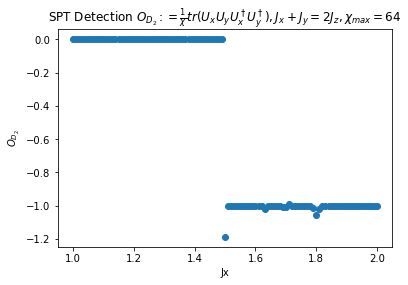

In [156]:
xs, ys = get_detector_list(chi=64)
plt.plot(xs, ys, 'o')
plt.xlabel('Jx')
plt.ylabel(r'$O_{D_2}$')
plt.title(r'SPT Detection $O_{D_2}:= \frac{1}{\chi} tr(U_x U_y U_x^\dagger U_y^\dagger), J_x+J_y = 2J_z, \chi_{max}=64$')

Text(0.5, 1.0, 'SPT Detection $O_{D_2}:= \\frac{1}{\\chi} tr(U_x U_y U_x^\\dagger U_y^\\dagger), J_x+J_y = 2J_z, \\chi_{max}=64$')

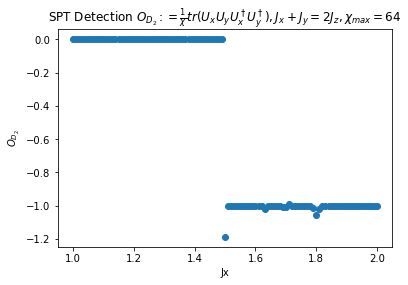

In [158]:
plt.plot(xs, ys, 'o')
plt.xlabel('Jx')
plt.ylabel(r'$O_{D_2}$')
plt.title(r'SPT Detection $O_{D_2}:= \frac{1}{\chi} tr(U_x U_y U_x^\dagger U_y^\dagger), J_x+J_y = 2J_z, \chi_{max}=64$')

/home/jerry/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'SPT Detection $O_{D_2}:= \\frac{1}{\\chi} tr(U_x U_y U_x^\\dagger U_y^\\dagger), J_x+J_y = 2J_z, \\chi_{max}=128$')

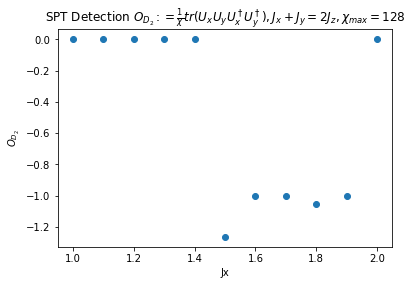

In [152]:
plt.plot(Jx_list, psi_list_128, 'o')
plt.xlabel('Jx')
plt.ylabel(r'$O_{D_2}$')
plt.title(r'SPT Detection $O_{D_2}:= \frac{1}{\chi} tr(U_x U_y U_x^\dagger U_y^\dagger), J_x+J_y = 2J_z, \chi_{max}=128$')